## [QCA] Surfacing promos experiment results

_Mathias Cardarello_
August 2024

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import trino
import os

## Viz parameters
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", None)
palette_glovo = ["#00A082", "#F2CC38", "#313131", "#8080E7", "#DB6668", "#A6A6A6", "#10A192", "#F7CC48", "#613241", "#2090E8", "#DB1158", "#A2A1A7"]
sns.set_palette(palette_glovo)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Montserrat'
sns.set_style("white")
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 8, 'axes.titlesize': 12})
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
pd.options.display.max_colwidth = 100

/Users/mathias.cardarello/Documents/Queries and notebooks/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Experiment results analysis

#### Harmony metric

In [122]:
from long_term_exp_impact.load_data import get_harmony_data, agg_harmony_data, create_metrics_query_config, _get_starburst_engine

In [123]:
from dotenv import load_dotenv
load_dotenv('/Users/mathias.cardarello/Documents/Queries and notebooks/WIP/.env')

True

In [124]:
conn = _get_starburst_engine()

In [125]:
exposures_sql_path = "/Users/mathias.cardarello/Documents/Queries and notebooks/WIP/[QCA-2832] Surfacing Promos/exposures.sql"
exposures_sql_config = {
    'end_date':"2024-08-17",
    'num_days':44
}
metrics_query_config = create_metrics_query_config(
    end_date="2024-08-17",
    num_days=44,
    city_codes="all"
)

In [126]:
# run query
df = get_harmony_data(
    conn=conn,
    exposures_sql_path=exposures_sql_path,
    exposure_sql_config=exposures_sql_config,
    metrics_query_config=metrics_query_config,
)

# aggregate data
df_agg = df.pipe(agg_harmony_data, groupby_cols=("customer_id", "variant"))

Started collecting data for harmony metrics ...
Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/5deceb5799b5bb9c6d623973b42c1b016bb3d25b862b25a2fc4360bdfed8d1ff
Started collecting data for customer exposures using your query ...
Started processing the data to create the final dataset for analysis ...
Loading data is completed.


In [127]:
## Set working directory
os.chdir('/Users/mathias.cardarello/Documents/Queries and notebooks/WIP/[QCA-2832] Surfacing Promos')

In [128]:
df_agg.to_csv('df_promos_harmony.csv')
#df_agg = pd.read_csv('df_promos_agg_harmony.csv')

In [129]:
df_agg = df_agg.iloc[:,1:]

print(df_agg.shape)
df_agg.head()

(1995697, 13)


,variant,total_orders_cancelled,total_orders_delivered,total_dt_minutes,total_cdt_minutes,total_orders_created,total_long_orders,total_late_orders,total_cpo,total_cm,total_ads_revenue,total_delivered_orders_eta,one
0,Control Group,0.00000,3.00000,85.41667,41.93333,3.00000,0.00000,0.00000,10.77090,2.95946,0.00000,3.00000,1
1,Promotions enabled,2.00000,16.00000,398.53333,233.30278,18.00000,0.00000,0.00000,41.50710,69.73640,1.78744,14.00000,1
2,Control Group,0.00000,6.00000,160.65000,82.26944,6.00000,0.00000,0.00000,15.85000,42.93130,1.78744,5.00000,1
3,Promotions enabled,0.00000,11.00000,224.20000,145.38333,12.00000,0.00000,0.00000,34.96450,12.69610,4.55218,11.00000,1
4,Promotions enabled,0.00000,1.00000,21.70000,16.81667,1.00000,0.00000,0.00000,0.00000,24.82559,0.89372,1.00000,1


In [130]:
df_agg.variant.unique()

array(['Control Group', 'Promotions enabled'], dtype=object)

In [131]:
## Rename variant values
df_agg['variant'] = df_agg['variant'].replace({'Promotions enabled': 'treatment', 'Control Group': 'control'})

In [132]:
df_agg.variant.unique()

array(['control', 'treatment'], dtype=object)

In [133]:
### Harmony inference
from long_term_exp_impact import make_inference

alpha=0.1
make_inference(
    df=df_agg,
    alpha=alpha
)

{'estimand': 'relative effect on 1y CM',
 'point_estimate': -0.004598499766760101,
 'ci_low': -0.010180084148633601,
 'ci_upp': 0.000983084615113399,
 'std_err': 0.0033933623578520236,
 'alpha': 0.1,
 'n_largest': 998047}

We cannot reject the hypothesis that the feature has no effect on the long term CM at a 10% significance level.

In [134]:
### Understand the results by checking the effects on proxy metrics
from long_term_exp_impact.inference import add_metrics_at_unit_level, get_metrics_point_estimates
from long_term_exp_impact.config import METRICS
from long_term_exp_impact.metric import parse_metrics

In [135]:
proxy_results = get_metrics_point_estimates(add_metrics_at_unit_level(df_agg, parse_metrics(METRICS)))
proxy_results

{'m_cancellation_rate': {'control': 0.03282498285673452,
  'treatment': 0.0326105574109067},
 'm_customer_dt': {'control': 32.85403837281769,
  'treatment': 32.852647677900606},
 'm_courier_dt': {'control': 20.69098588555916,
  'treatment': 20.691586060506463},
 'm_orders_created': {'control': 4.795058749738239,
  'treatment': 4.783304766200572},
 'm_long_orders_rate': {'control': 0.05865007003107312,
  'treatment': 0.05847359929672247},
 'm_late_orders_rate': {'control': 0.034917797365772746,
  'treatment': 0.03469931177170392},
 'm_cpo': {'control': 2.4573984517946657, 'treatment': 2.4581938315382215},
 'm_cm': {'control': 9.378228788226926, 'treatment': 9.3236825421785},
 'm_ads': {'control': 0.9533263768111063, 'treatment': 0.9498836373680762},
 'units': {'control': 998047, 'treatment': 997650}}

In [42]:
CONFIG = {
  "host": "starburst.g8s-data-platform-prod.glovoint.com",
  "port": 443,
  "http_scheme": "https",
  "auth": trino.auth.OAuth2Authentication()
}

starburst_conn = trino.dbapi.connect(**CONFIG)

cur = starburst_conn.cursor()
cur.execute("SHOW CATALOGS")
rows = cur.fetchall()
print(rows)

Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/4bce900e9dfea0d3e76146bbcdedb282f5907206658872348994db9619418531
[['delivery_hero'], ['delivery_hero_dhub_glovo'], ['delivery_hero_fulfillment_dwh_production'], ['delta'], ['feature_toggles'], ['hive'], ['legacy_delta'], ['legacy_lake'], ['sandbox'], ['sandbox_dp'], ['sensitive_delta'], ['sensitive_hive'], ['system']]


In [43]:
## Set working directory
os.chdir('/Users/mathias.cardarello/Documents/Queries and notebooks/WIP/[QCA-2832] Surfacing Promos')

In [44]:
import os
os.getcwd()

'/Users/mathias.cardarello/Documents/Queries and notebooks/WIP/[QCA-2832] Surfacing Promos'

#### Check for flickering across experiment versions

In [21]:
%%time

## Open and read the SQL file
with open('versions_check.sql', 'r') as file:
    sql_check = file.read()

df_check = pd.read_sql(sql_check, starburst_conn)

<timed exec>:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


CPU times: user 70.9 ms, sys: 9.2 ms, total: 80.1 ms
Wall time: 12.1 s


In [22]:
df_check

,variant_v1,variant_v2,participants
0,None,Promotions enabled,2535211
1,Control Group,None,1166174
2,Promotions enabled,None,1167883
3,Promotions enabled,Promotions enabled,2372992
4,Control Group,Control Group,2371281
5,None,Control Group,2535134


In [25]:
# Function to check if all non-None items in a list are identical
def all_same(items):
    items = [item for item in items if item is not None]
    return all(x == items[0] for x in items) if items else True

df_check['all_same'] = df_check.apply(lambda row: all_same([row['variant_v1'], row['variant_v2']]), axis=1)

df_different = df_check[~df_check['all_same']]

print(df_different[['variant_v1', 'variant_v2', 'participants']])

Empty DataFrame
Columns: [variant_v1, variant_v2, participants]
Index: []


There is no flickering for the three versions of the Experiment toggle

#### Retrieve main results

##### Customer level

In [49]:
%%time
### Is faster to download the data into a csv or parquet from Starburst and then load it into a pandas dataframe

df_customer = pd.read_csv('df_customer_metrics.csv')
print(df_customer.shape)

(2555664, 14)
CPU times: user 3.34 s, sys: 746 ms, total: 4.08 s
Wall time: 4.22 s


In [66]:
def check_duplicates(df, key_col):
    if (df[key_col].size==df[key_col].nunique()):
        print('Success! No duplicates')
    else:
        print("Check for duplicates..\nExample:")
        print("Number of rows in df: {}, number of unique keys: {}".format(df[key_col].size,
                                                                         df[key_col].nunique()))
        duplicates = df[df.duplicated(key_col)]
        display(df[df[key_col]==duplicates.iloc[0,:][key_col]].T)

In [68]:
check_duplicates(df_customer, 'customer_id')

Success! No duplicates


In [50]:
df_customer.describe()

,customer_id,total_created_orders,groceries_created_orders,groceries_disc_created_orders,total_delivered_orders,groceries_delivered_orders,groceries_disc_delivered_orders,total_delivered_gmv_eur,groceries_delivered_gmv_eur,total_delivered_disc_gmv_eur,groceries_delivered_disc_gmv_eur
count,2555664.00000,2555664.00000,2555664.00000,2555664.00000,2555664.00000,2555664.00000,2555664.00000,2555664.00000,2555664.00000,2555664.00000,2555664.00000
mean,99179174.54849,3.82788,1.22653,0.17632,3.71252,1.17588,0.17501,75.44597,26.10710,24.00230,7.35967
std,61224955.59215,7.20574,3.42481,0.88628,7.01568,3.31092,0.88272,221.07247,158.44756,165.46388,139.94580
min,220.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,39237955.75000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,118439073.50000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,21.20000,0.00000,0.00000,0.00000
75%,157535539.75000,4.00000,1.00000,0.00000,4.00000,1.00000,0.00000,73.16000,15.97027,13.38264,0.00000
max,175620984.00000,1118.00000,1118.00000,556.00000,1116.00000,1116.00000,556.00000,190048.00165,189904.01503,189816.95286,189816.95286


In [51]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2555664 entries, 0 to 2555663
Data columns (total 14 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   customer_id                       int64  
 1   variant                           object 
 2   first_exposure_date               object 
 3   is_recurrent_groceries            object 
 4   total_created_orders              int64  
 5   groceries_created_orders          int64  
 6   groceries_disc_created_orders     int64  
 7   total_delivered_orders            int64  
 8   groceries_delivered_orders        int64  
 9   groceries_disc_delivered_orders   int64  
 10  total_delivered_gmv_eur           float64
 11  groceries_delivered_gmv_eur       float64
 12  total_delivered_disc_gmv_eur      float64
 13  groceries_delivered_disc_gmv_eur  float64
dtypes: float64(4), int64(7), object(3)
memory usage: 273.0+ MB


In [52]:
## Check split of customers by groups

df_customer.groupby('variant')[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df_customer['customer_id'].nunique())

,customer_id,perc
,nunique,
variant,,
Control Group,1278092,0.50010
Promotions enabled,1277572,0.49990


In [53]:
## Check split of customer by GNC/GRC

df_customer.groupby(['is_recurrent_groceries', 'variant'])[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df_customer['customer_id'].nunique())

customer_id    perc
                                              nunique        
is_recurrent_groceries variant                               
False                  Control Group           555838 0.21749
                       Promotions enabled      556320 0.21768
True                   Control Group           708011 0.27704
                       Promotions enabled      707053 0.27666

In [54]:
### Check outliers

round(df_customer[['total_delivered_gmv_eur', 'groceries_delivered_disc_gmv_eur']].describe(percentiles=[0, 0.5,0.95,0.99, 0.999, 0.9999]))

,total_delivered_gmv_eur,groceries_delivered_disc_gmv_eur
count,2555664.00000,2555664.00000
mean,75.00000,7.00000
std,221.00000,140.00000
min,0.00000,0.00000
0%,0.00000,0.00000
50%,21.00000,0.00000
95%,329.00000,28.00000
99%,790.00000,161.00000
99.9%,1878.00000,711.00000
99.99%,3845.00000,1903.00000


In [55]:
df_customers_exp = df_customer.query('groceries_delivered_disc_gmv_eur <= 2000')
df_customers_exp.describe()

,customer_id,total_created_orders,groceries_created_orders,groceries_disc_created_orders,total_delivered_orders,groceries_delivered_orders,groceries_disc_delivered_orders,total_delivered_gmv_eur,groceries_delivered_gmv_eur,total_delivered_disc_gmv_eur,groceries_delivered_disc_gmv_eur
count,2555440.00000,2555440.00000,2555440.00000,2555440.00000,2555440.00000,2555440.00000,2555440.00000,2555440.00000,2555440.00000,2555440.00000,2555440.00000
mean,99180143.75796,3.82569,1.22497,0.17548,3.71038,1.17435,0.17417,75.02465,25.71309,23.60885,6.97933
std,61224852.92876,7.16731,3.34860,0.80982,6.97658,3.23251,0.80594,176.64952,87.59475,99.80183,47.54056
min,220.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,39239320.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,118439488.50000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,21.20000,0.00000,0.00000,0.00000
75%,157536304.75000,4.00000,1.00000,0.00000,4.00000,1.00000,0.00000,73.13724,15.96249,13.37000,0.00000
max,175620984.00000,1105.00000,415.00000,200.00000,1105.00000,415.00000,200.00000,74686.64408,6949.79705,74686.64408,1999.56000


In [56]:
### Check groceries_delivered_disc_gmv_eur by variant

df_customers_exp.groupby('variant')[['groceries_delivered_disc_gmv_eur']].agg(['mean', 'median', 'std'])

groceries_delivered_disc_gmv_eur                 
                                               mean  median      std
variant                                                             
Control Group                               6.93251 0.00000 47.08800
Promotions enabled                          7.02617 0.00000 47.98902

In [57]:
df_customers_exp.groupby(['is_recurrent_groceries', 'variant'])[['groceries_delivered_disc_gmv_eur']].agg(['mean', 'median', 'std'])

groceries_delivered_disc_gmv_eur                 
                                                                      mean  median      std
is_recurrent_groceries variant                                                             
False                  Control Group                               1.70734 0.00000 20.13771
                       Promotions enabled                          1.70591 0.00000 19.68863
True                   Control Group                              11.03886 0.00000 60.16829
                       Promotions enabled                         11.21591 0.00000 61.45275

In [58]:
## Check split of customer by GNC/GRC

df_customers_exp.groupby(['is_recurrent_groceries', 'variant'])[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df_customers_exp['customer_id'].nunique())

customer_id    perc
                                              nunique        
is_recurrent_groceries variant                               
False                  Control Group           555823 0.21751
                       Promotions enabled      556309 0.21770
True                   Control Group           707923 0.27703
                       Promotions enabled      706945 0.27664

In [59]:
### Quality check for is_groceries_recurrent

# Group by customer_id and check for both values in is_groceries_recurrent
customers_with_both_values = df_customers_exp.groupby('customer_id')['is_recurrent_groceries'].apply(lambda x: set(x) == {0, 1})

# Filter the DataFrame to get the customers with both values
df_customers_with_both_values = df_customers_exp[df_customers_exp['customer_id'].isin(customers_with_both_values[customers_with_both_values].index)]

# Display the result
print(df_customers_with_both_values)

Empty DataFrame
Columns: [customer_id, variant, first_exposure_date, is_recurrent_groceries, total_created_orders, groceries_created_orders, groceries_disc_created_orders, total_delivered_orders, groceries_delivered_orders, groceries_disc_delivered_orders, total_delivered_gmv_eur, groceries_delivered_gmv_eur, total_delivered_disc_gmv_eur, groceries_delivered_disc_gmv_eur]
Index: []


/var/folders/pr/g6zzn80n6d361nfqklq4dst40000gp/T/ipykernel_42011/2195457605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customers_exp['date'] = pd.to_datetime(df_customers_exp['first_exposure_date'])


                                              Experiment Information                                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃               ┃            ┃               ┃               ┃               ┃             ┃       ┃        Alpha ┃
┃ Name          ┃ Hypothesis ┃          Date ┃       Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing     │            │ 2024-07-04 to │   ['Groceries │     ['Control │       False │  0.05 │       0.0083 │
│ promos for    │            │    2024-08-16 │      discount │       Group', │             │       │              │
│ Groceries     │            │               │     delivered │   'Promotions │             │       │              │
│               │            │               │  GMV', 'Total │     enabled'] │             │       │              │
│               │            │               │       created │               │             │       │              │
│               │            │               │    orders per │               │             │       │              │
│               │            │               │    customer', │               │             │       │              │
│               │            │               │    'Groceries │               │             │       │              │
│               │            │               │       created │               │             │       │              │
│               │            │               │    orders per │               │             │       │              │
│               │            │               │    customer', │               │             │       │              │
│               │            │               │    'Groceries │               │             │       │              │
│               │            │               │     delivered │               │             │       │              │
│               │            │               │    orders per │               │             │       │              │
│               │            │               │    customer', │               │             │       │              │
│               │            │               │    'Groceries │               │             │       │              │
│               │            │               │     delivered │               │             │       │              │
│               │            │               │  promo orders │               │             │       │              │
│               │            │               │           per │               │             │       │              │
│               │            │               │    customer', │               │             │       │              │
│               │            │               │    'Groceries │               │             │       │              │
│               │            │               │     delivered │               │             │       │              │
│               │            │               │         GMV'] │               │             │       │              │
└───────────────┴────────────┴───────────────┴───────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DISCOUNT DELIVERED GMV                                                                                │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,6.93251,7.02617,0.09366,-0.06326,0.25058,0.11534,0.05948,False


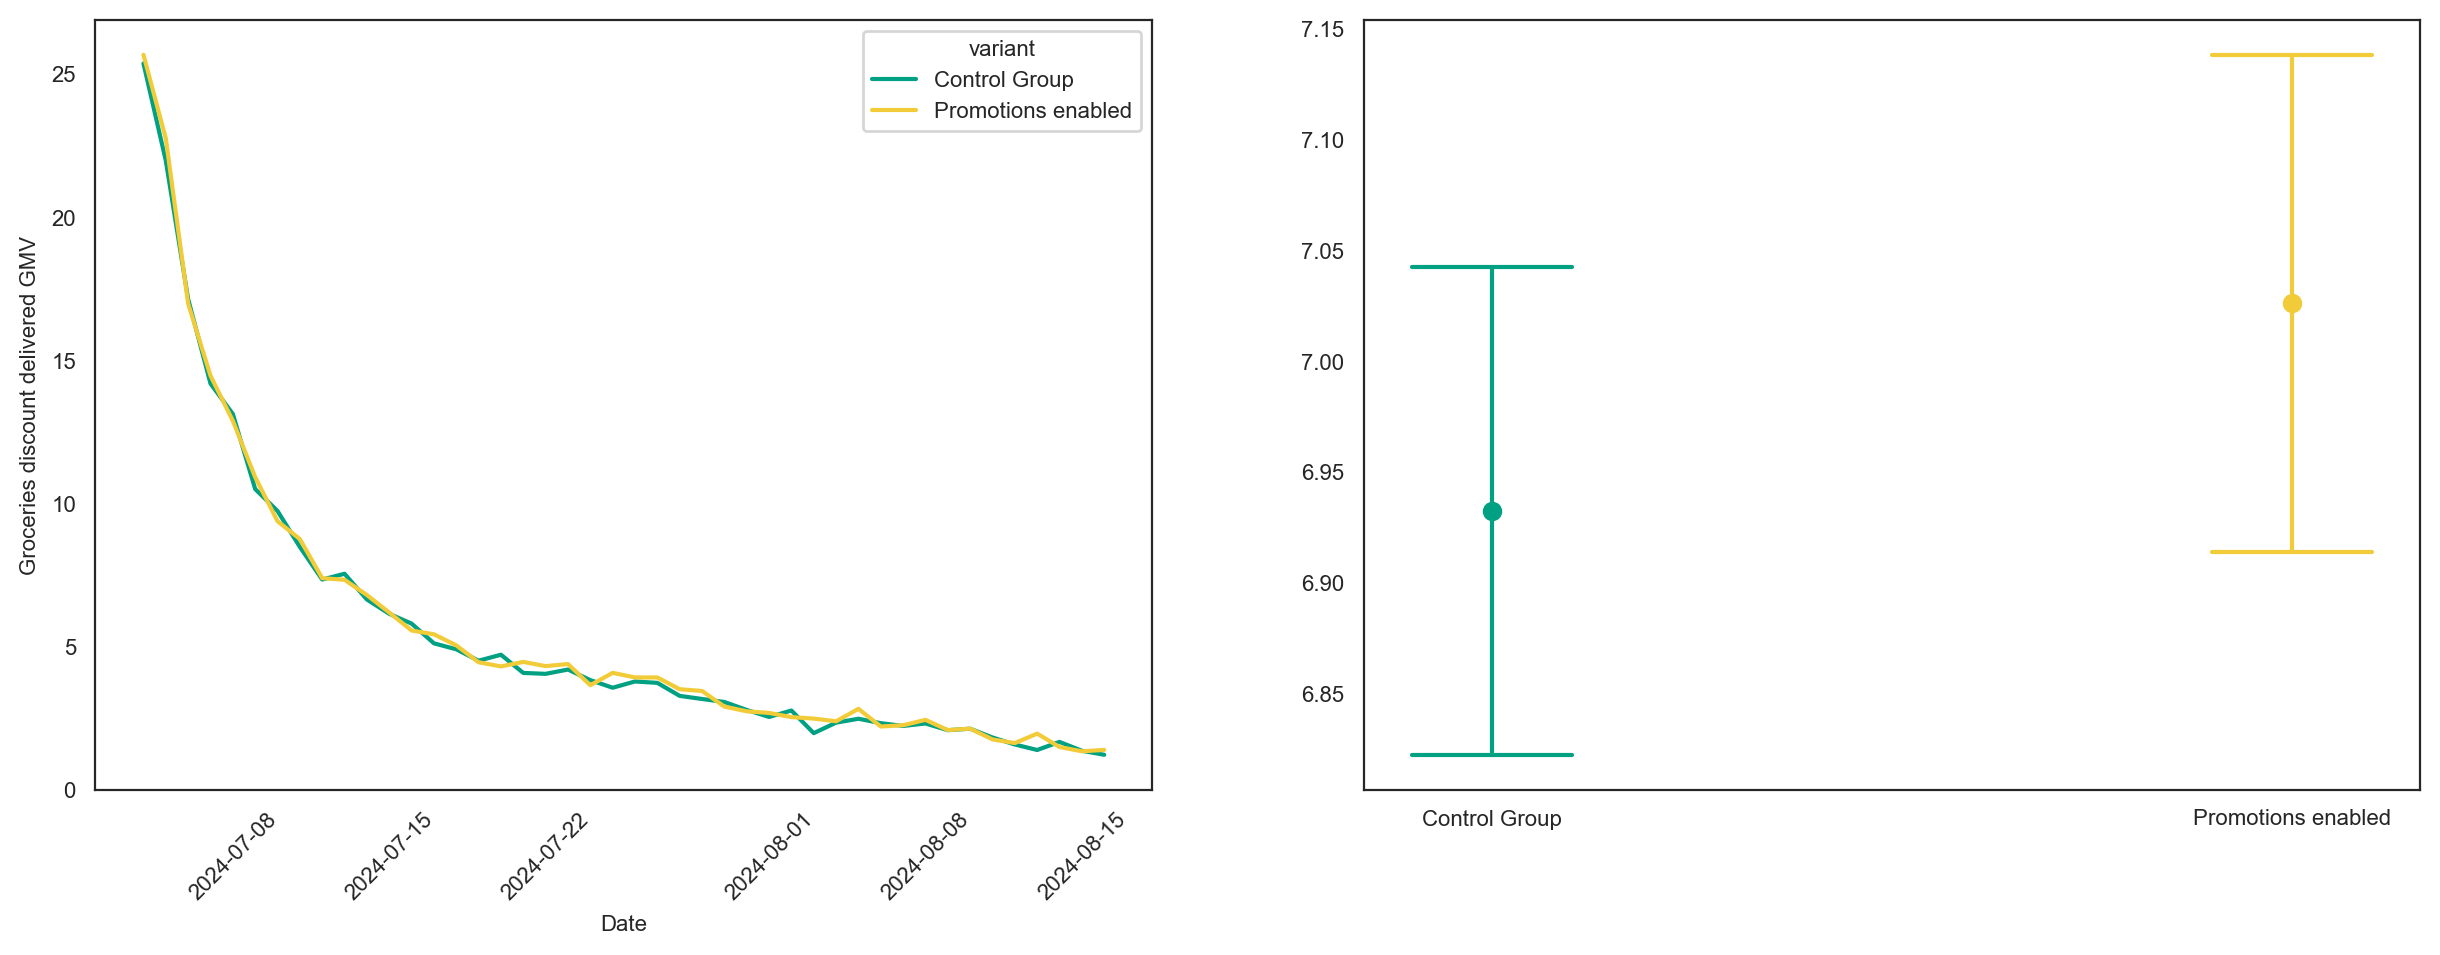

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ TOTAL CREATED ORDERS PER CUSTOMER                                                                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,3.82813,3.82325,-0.00488,-0.02854,0.01878,0.58629,0.00897,False


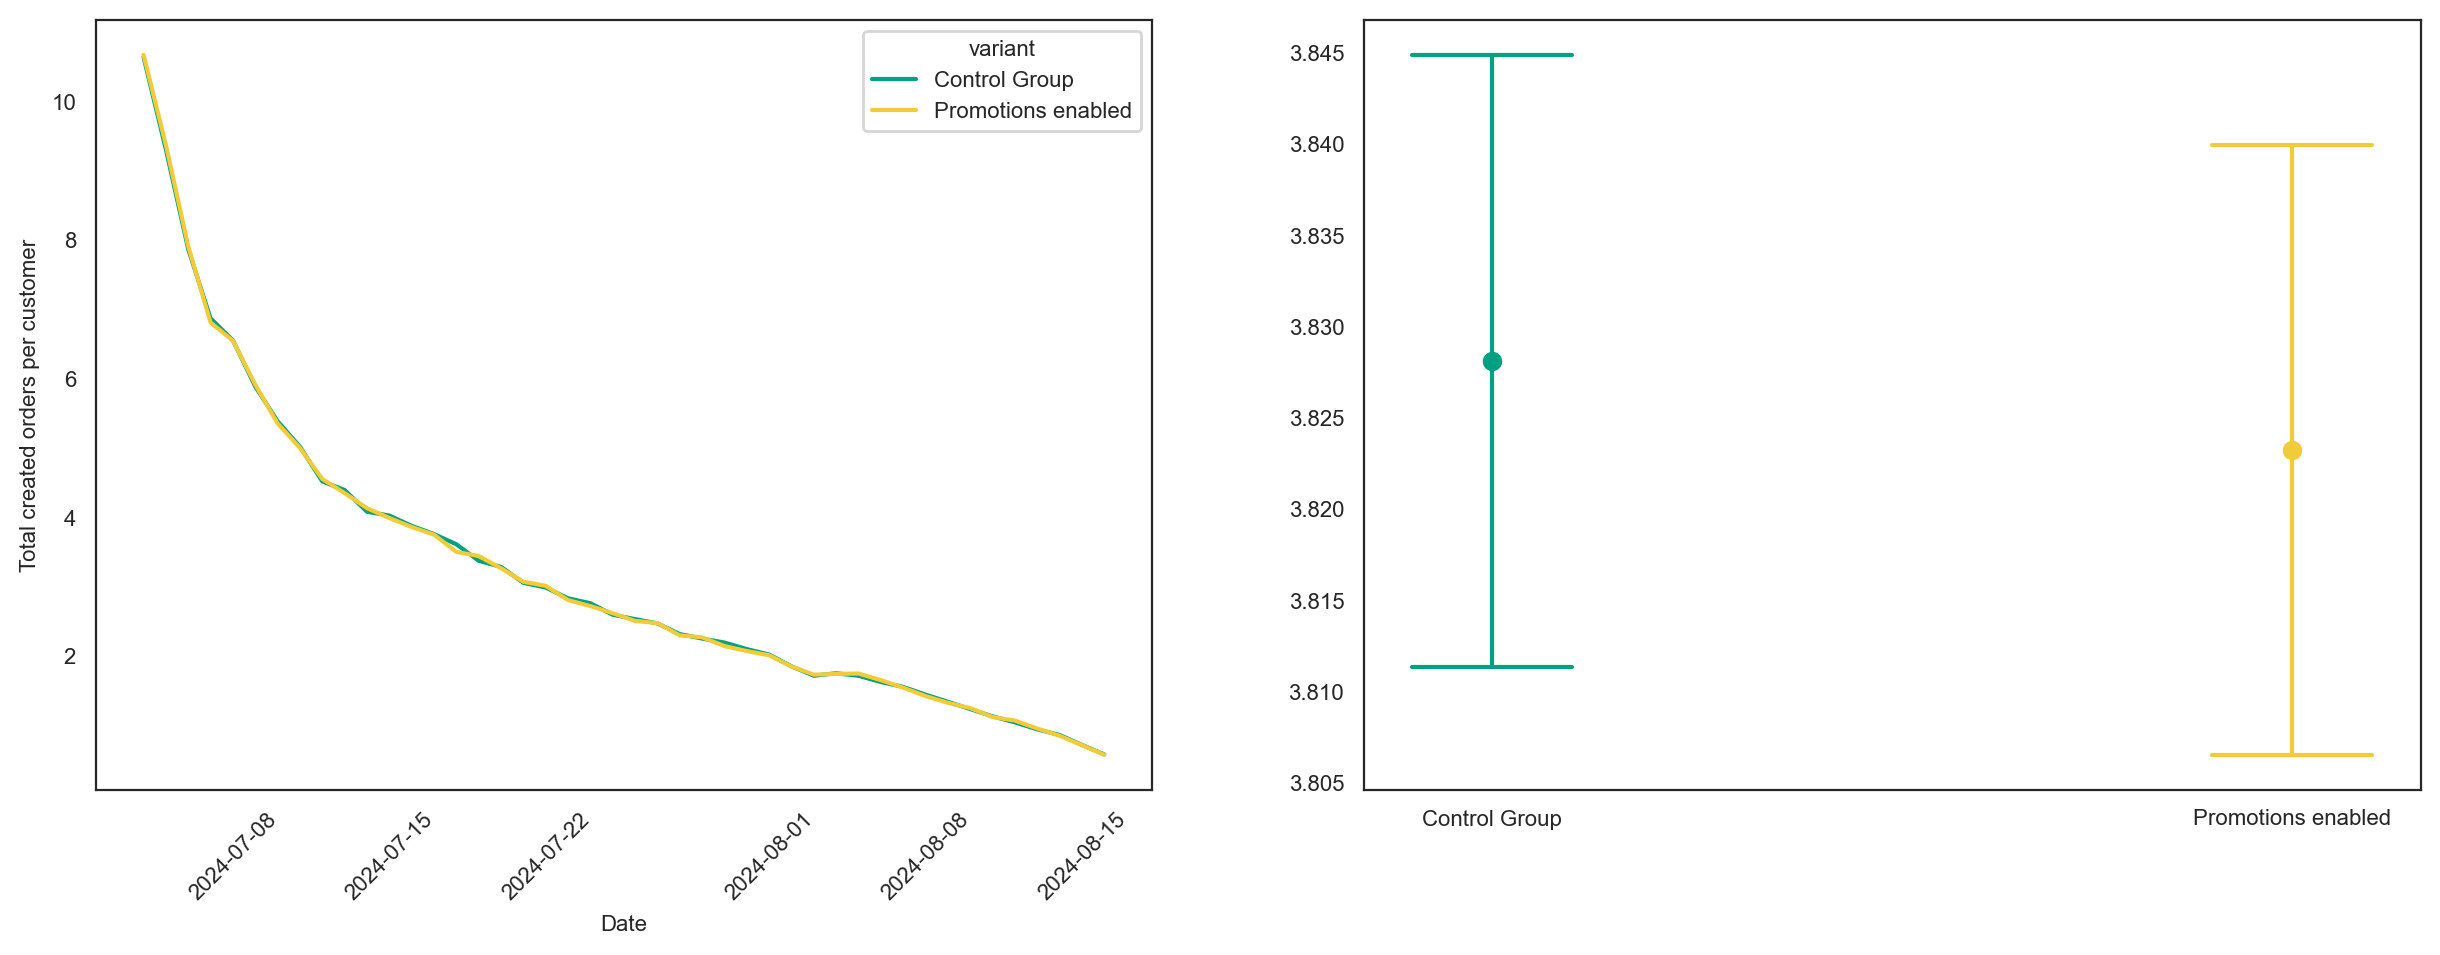

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES CREATED ORDERS PER CUSTOMER                                                                           │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,1.22739,1.22255,-0.00484,-0.01589,0.00622,0.24834,0.00419,False


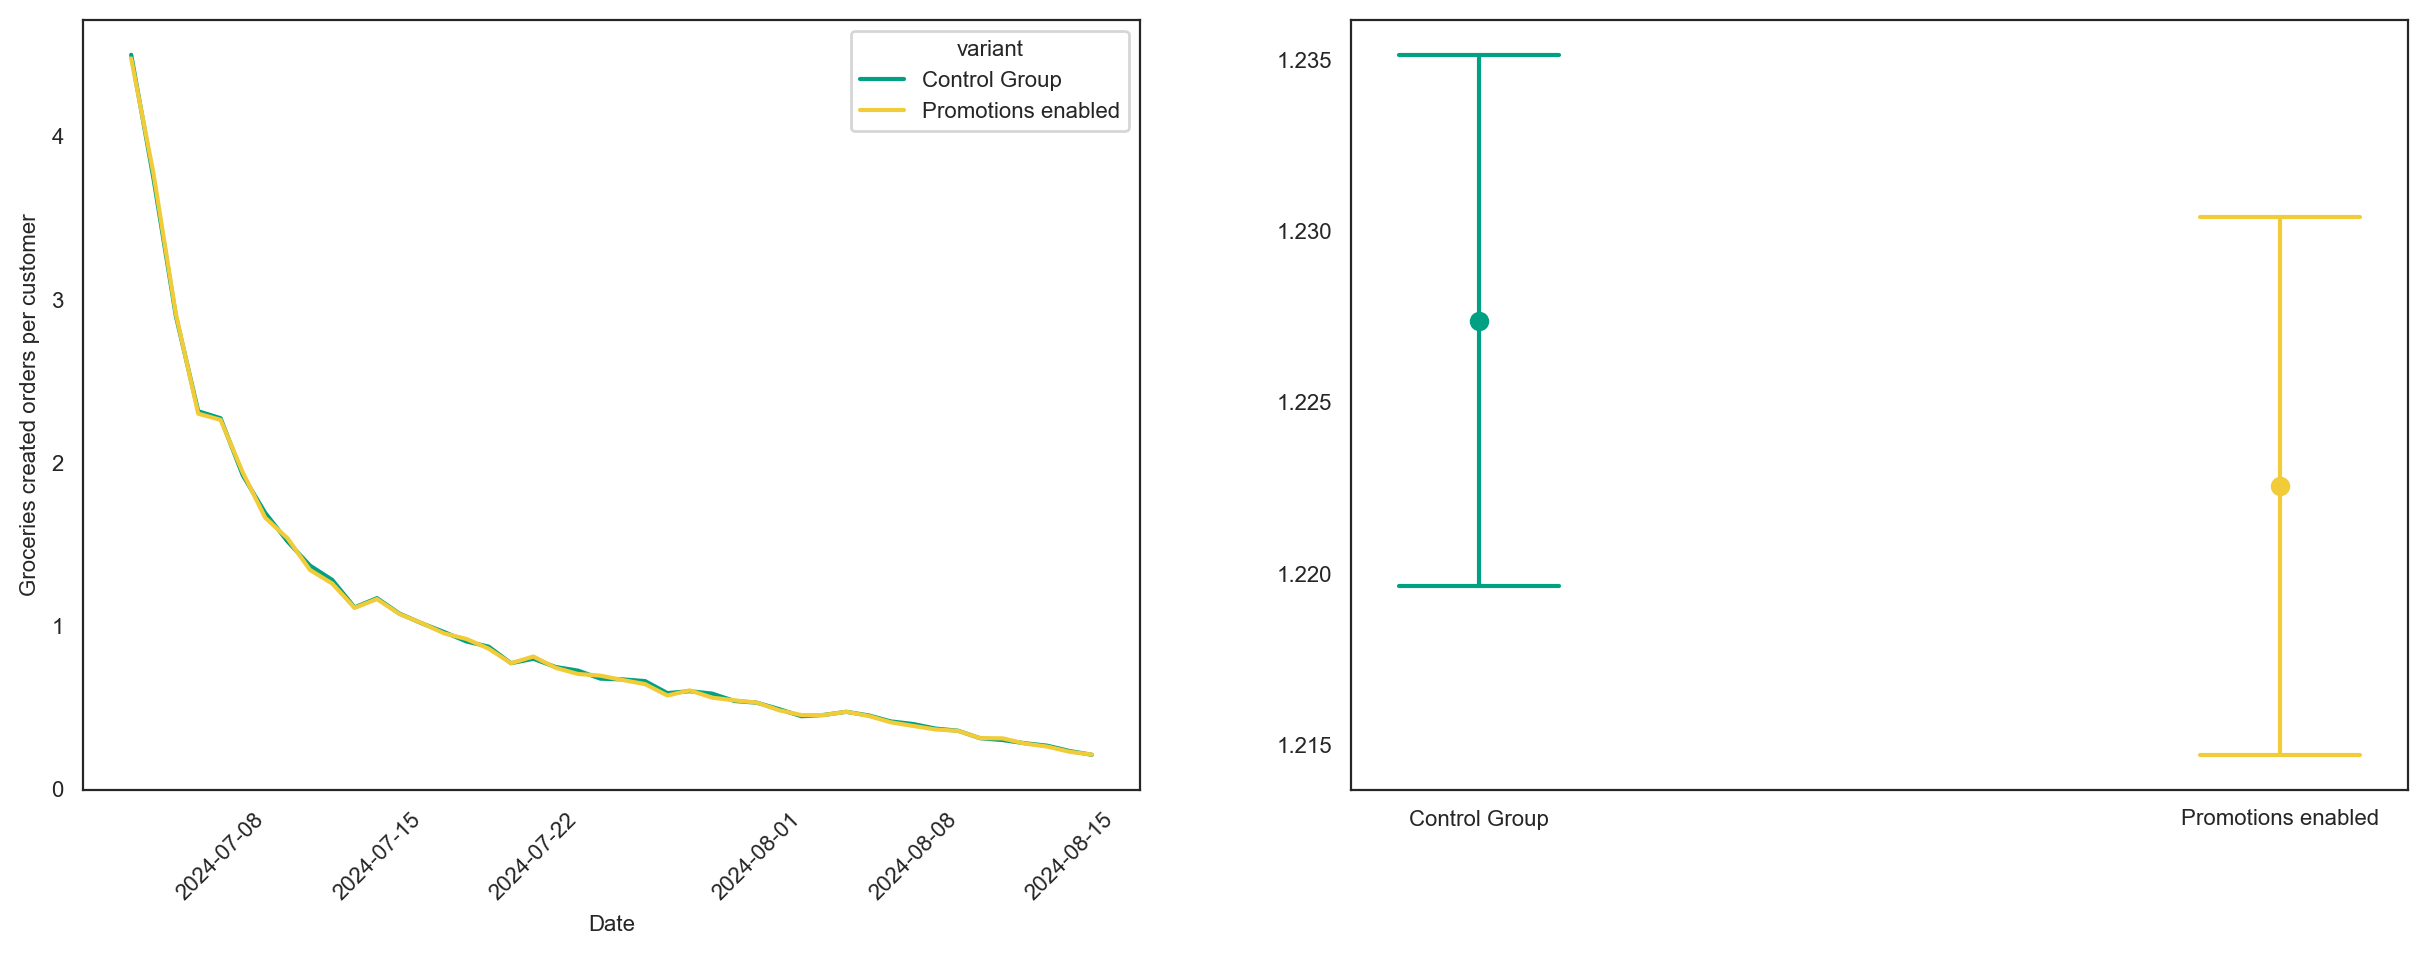

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED ORDERS PER CUSTOMER                                                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,1.17659,1.17211,-0.00447,-0.01514,0.00619,0.26853,0.00404,False


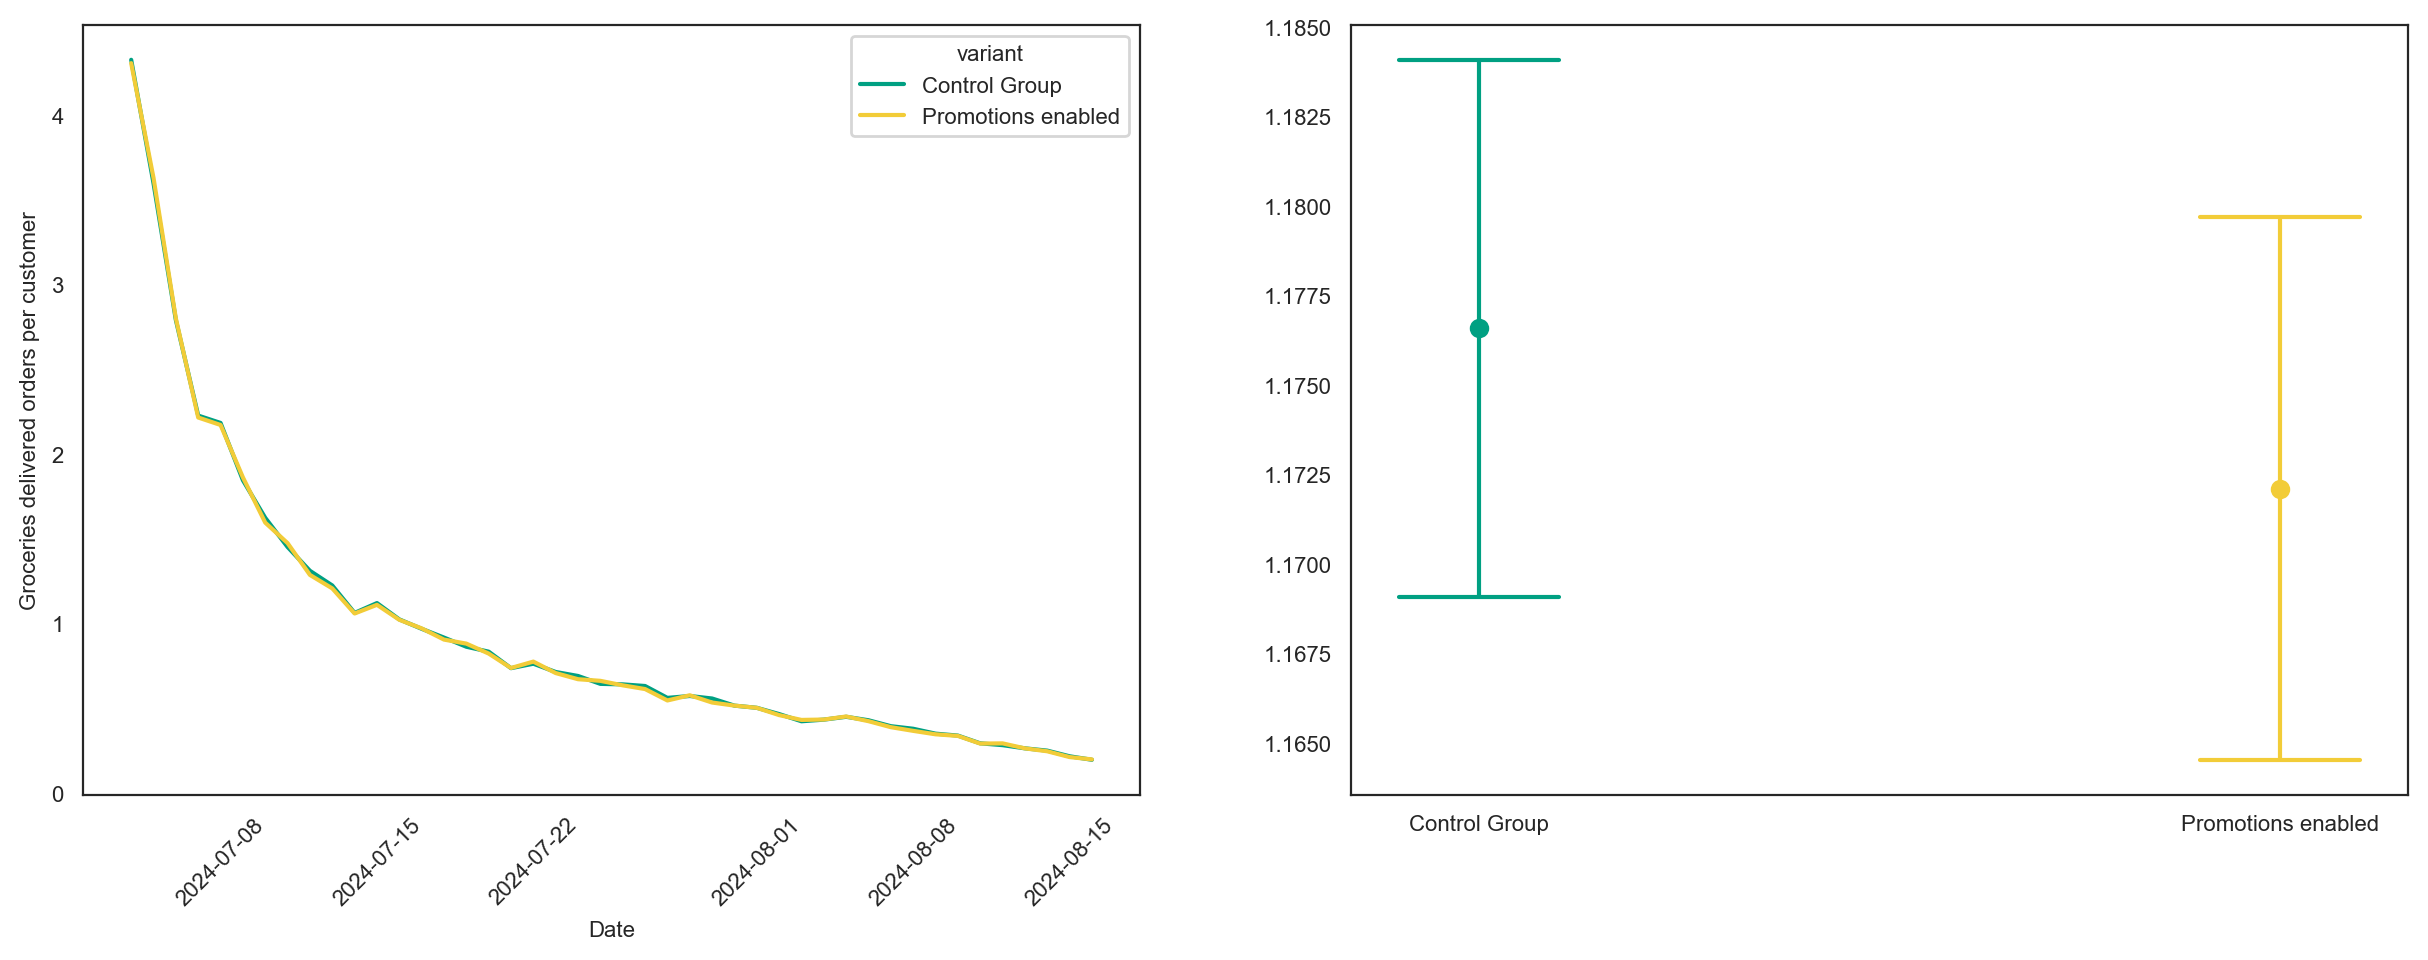

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED PROMO ORDERS PER CUSTOMER                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.17442,0.17392,-0.00051,-0.00317,0.00215,0.61518,0.00101,False


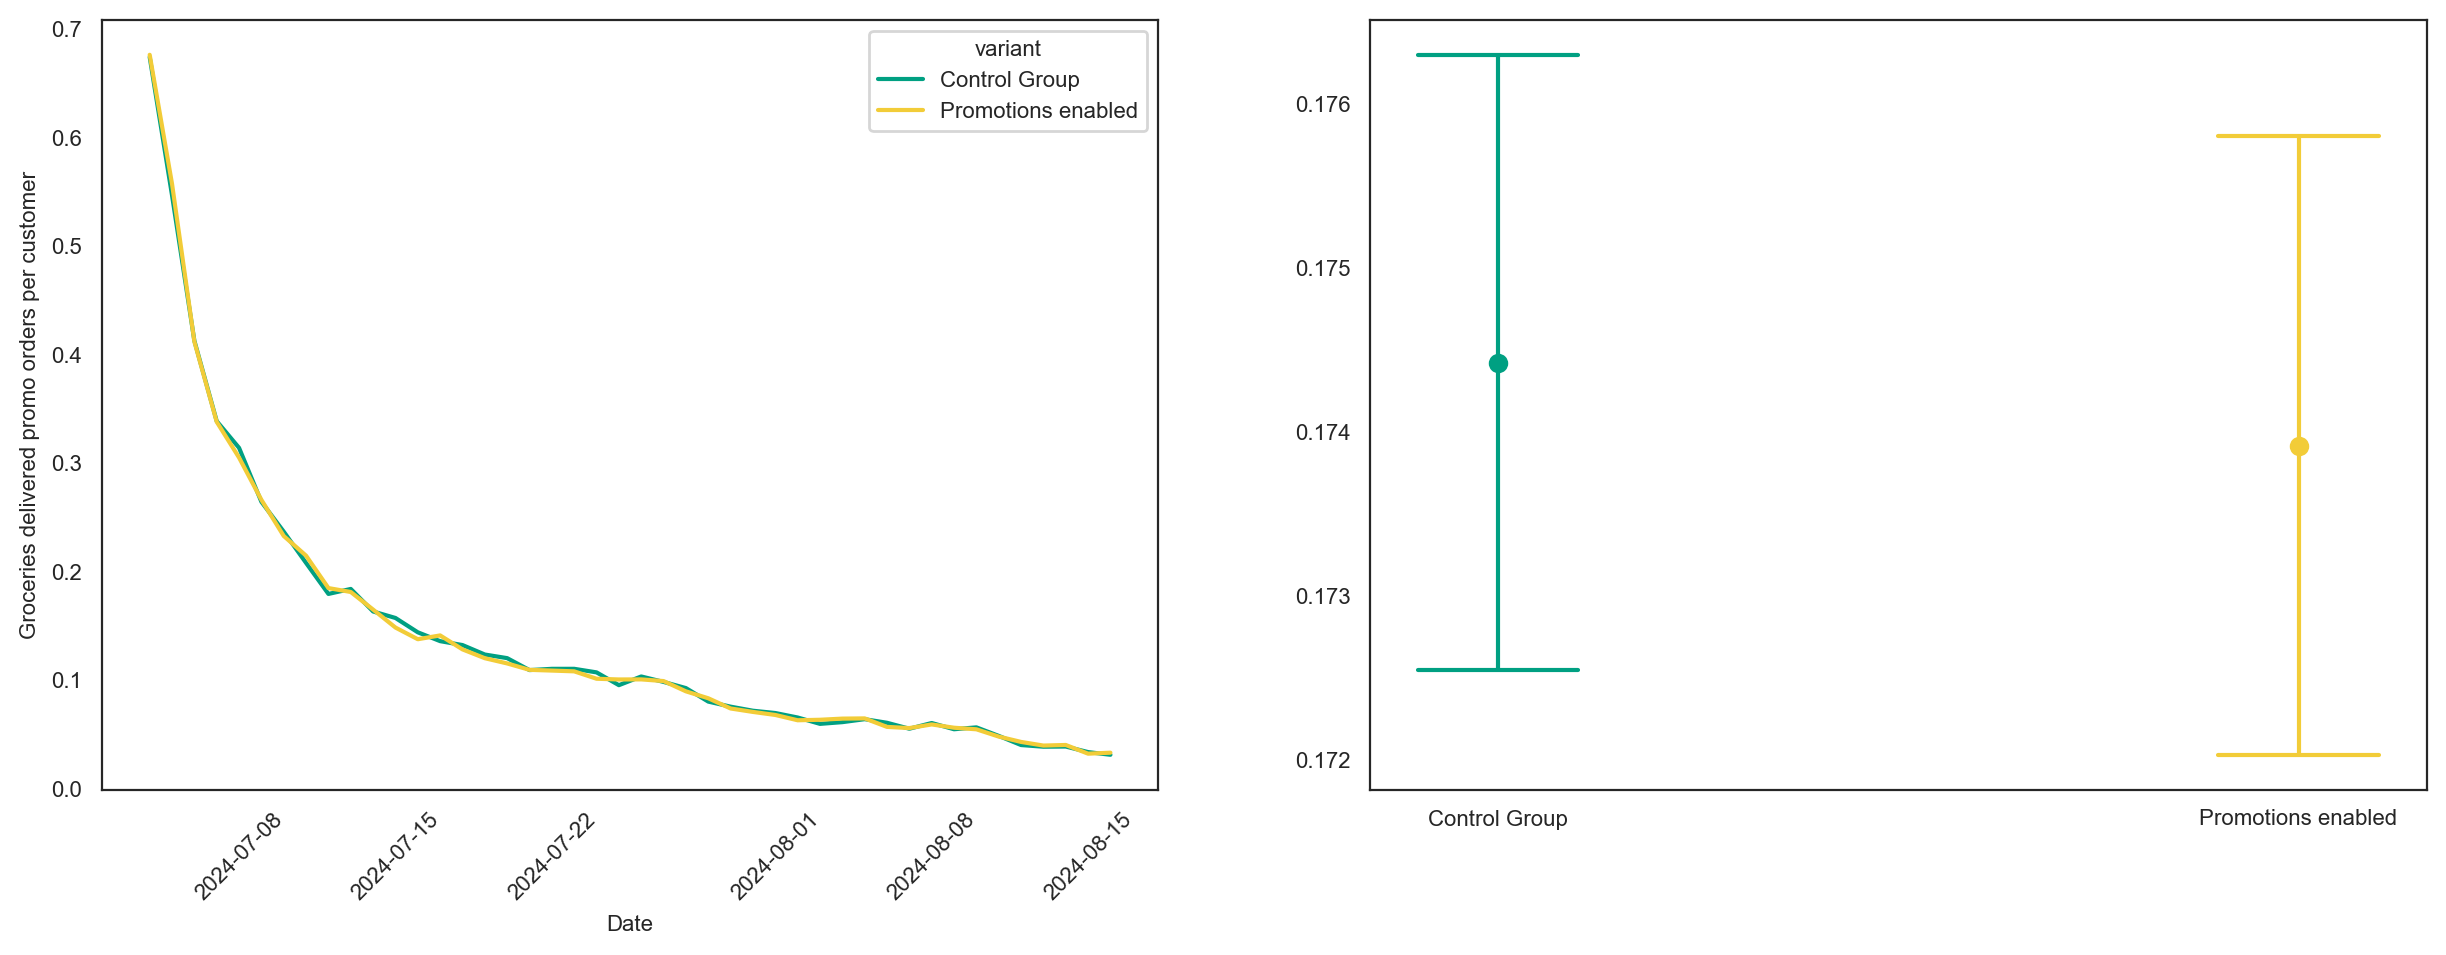

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED GMV                                                                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,25.76360,25.66257,-0.10103,-0.39016,0.18810,0.35658,0.10959,False


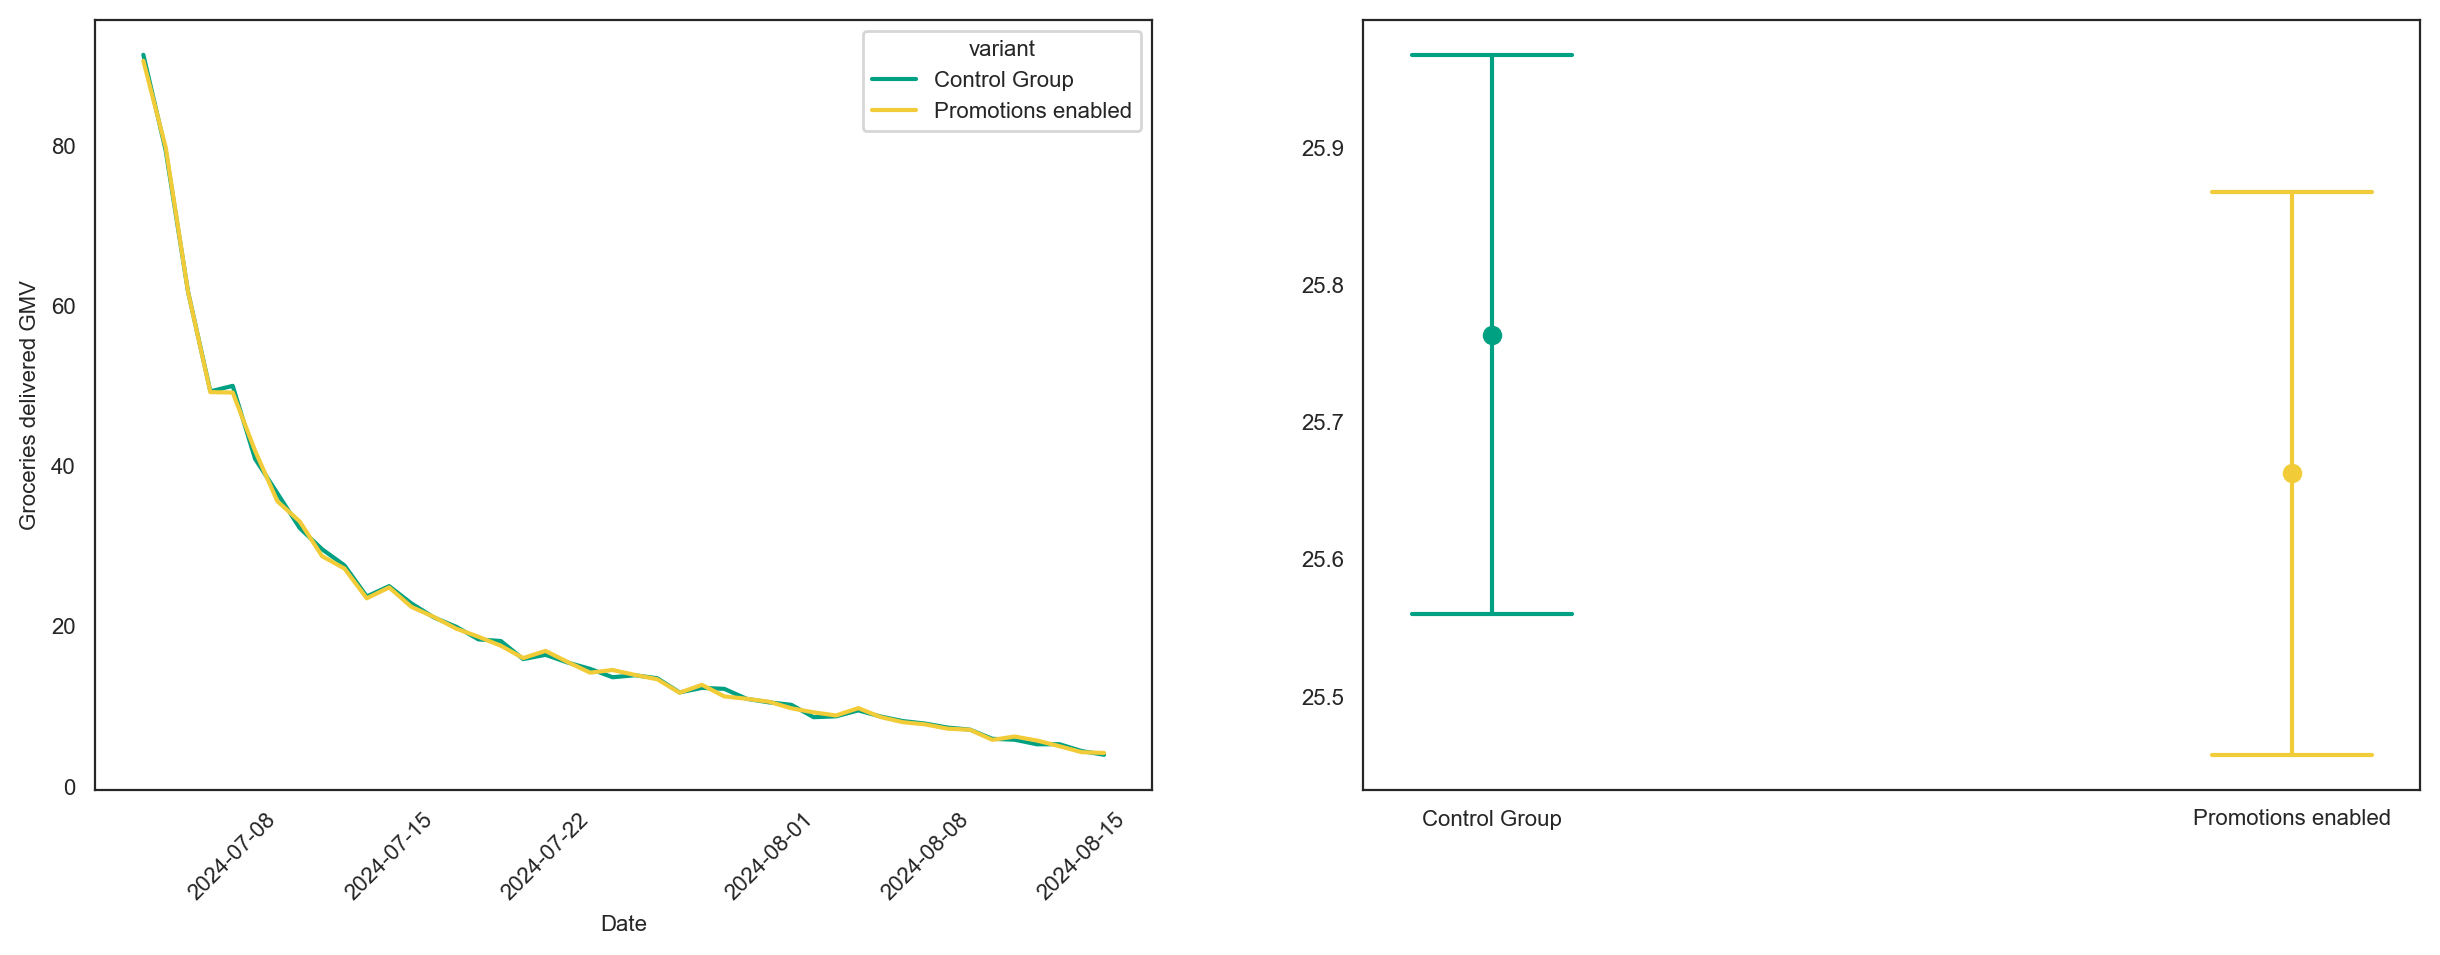

In [60]:
### Orders and GMV
from glovo_experimentation_analytics.analytics.experiment import Experiment

df_customers_exp['date'] = pd.to_datetime(df_customers_exp['first_exposure_date'])

experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "",
        "start_date": "2024-07-04",
        "end_date": "2024-08-16",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "Groceries discount delivered GMV",
                "df": df_customers_exp,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_disc_gmv_eur",
            },   
            {
                "metric_name": "Total created orders per customer",
                "df": df_customers_exp,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "total_created_orders",
            },
            {
                "metric_name": "Groceries created orders per customer",
                "df": df_customers_exp,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_created_orders",
            },  
            {
                "metric_name": "Groceries delivered orders per customer",
                "df": df_customers_exp,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_orders",
            },  
            {
                "metric_name": "Groceries delivered promo orders per customer",
                "df": df_customers_exp,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_disc_delivered_orders",
            },  
            {
                "metric_name": "Groceries delivered GMV",
                "df": df_customers_exp,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_gmv_eur",
            },   
        ],    
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": False
    }

exp_fin = Experiment.from_dict(experiment_config)
exp_fin.full_analysis()

In [61]:
## Get scorecard
exp_fin_results = pd.DataFrame(exp_fin.get_scorecard_summary())
exp_fin_results.to_clipboard()

                                              Experiment Information                                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃               ┃            ┃               ┃               ┃               ┃             ┃       ┃        Alpha ┃
┃ Name          ┃ Hypothesis ┃          Date ┃       Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing     │            │ 2024-07-04 to │       ['GRC - │     ['Control │       False │  0.05 │       0.0125 │
│ promos for    │            │    2024-08-16 │     Groceries │       Group', │             │       │              │
│ Groceries     │            │               │      discount │   'Promotions │             │       │              │
│               │            │               │     delivered │     enabled'] │             │       │              │
│               │            │               │  GMV', 'GNC - │               │             │       │              │
│               │            │               │     Groceries │               │             │       │              │
│               │            │               │      discount │               │             │       │              │
│               │            │               │     delivered │               │             │       │              │
│               │            │               │  GMV', 'GRC - │               │             │       │              │
│               │            │               │     Groceries │               │             │       │              │
│               │            │               │     delivered │               │             │       │              │
│               │            │               │  GMV', 'GNC - │               │             │       │              │
│               │            │               │     Groceries │               │             │       │              │
│               │            │               │     delivered │               │             │       │              │
│               │            │               │         GMV'] │               │             │       │              │
└───────────────┴────────────┴───────────────┴───────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GRC - GROCERIES DISCOUNT DELIVERED GMV                                                                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,11.03886,11.21591,0.17705,-0.07835,0.43245,0.08336,0.10225,False


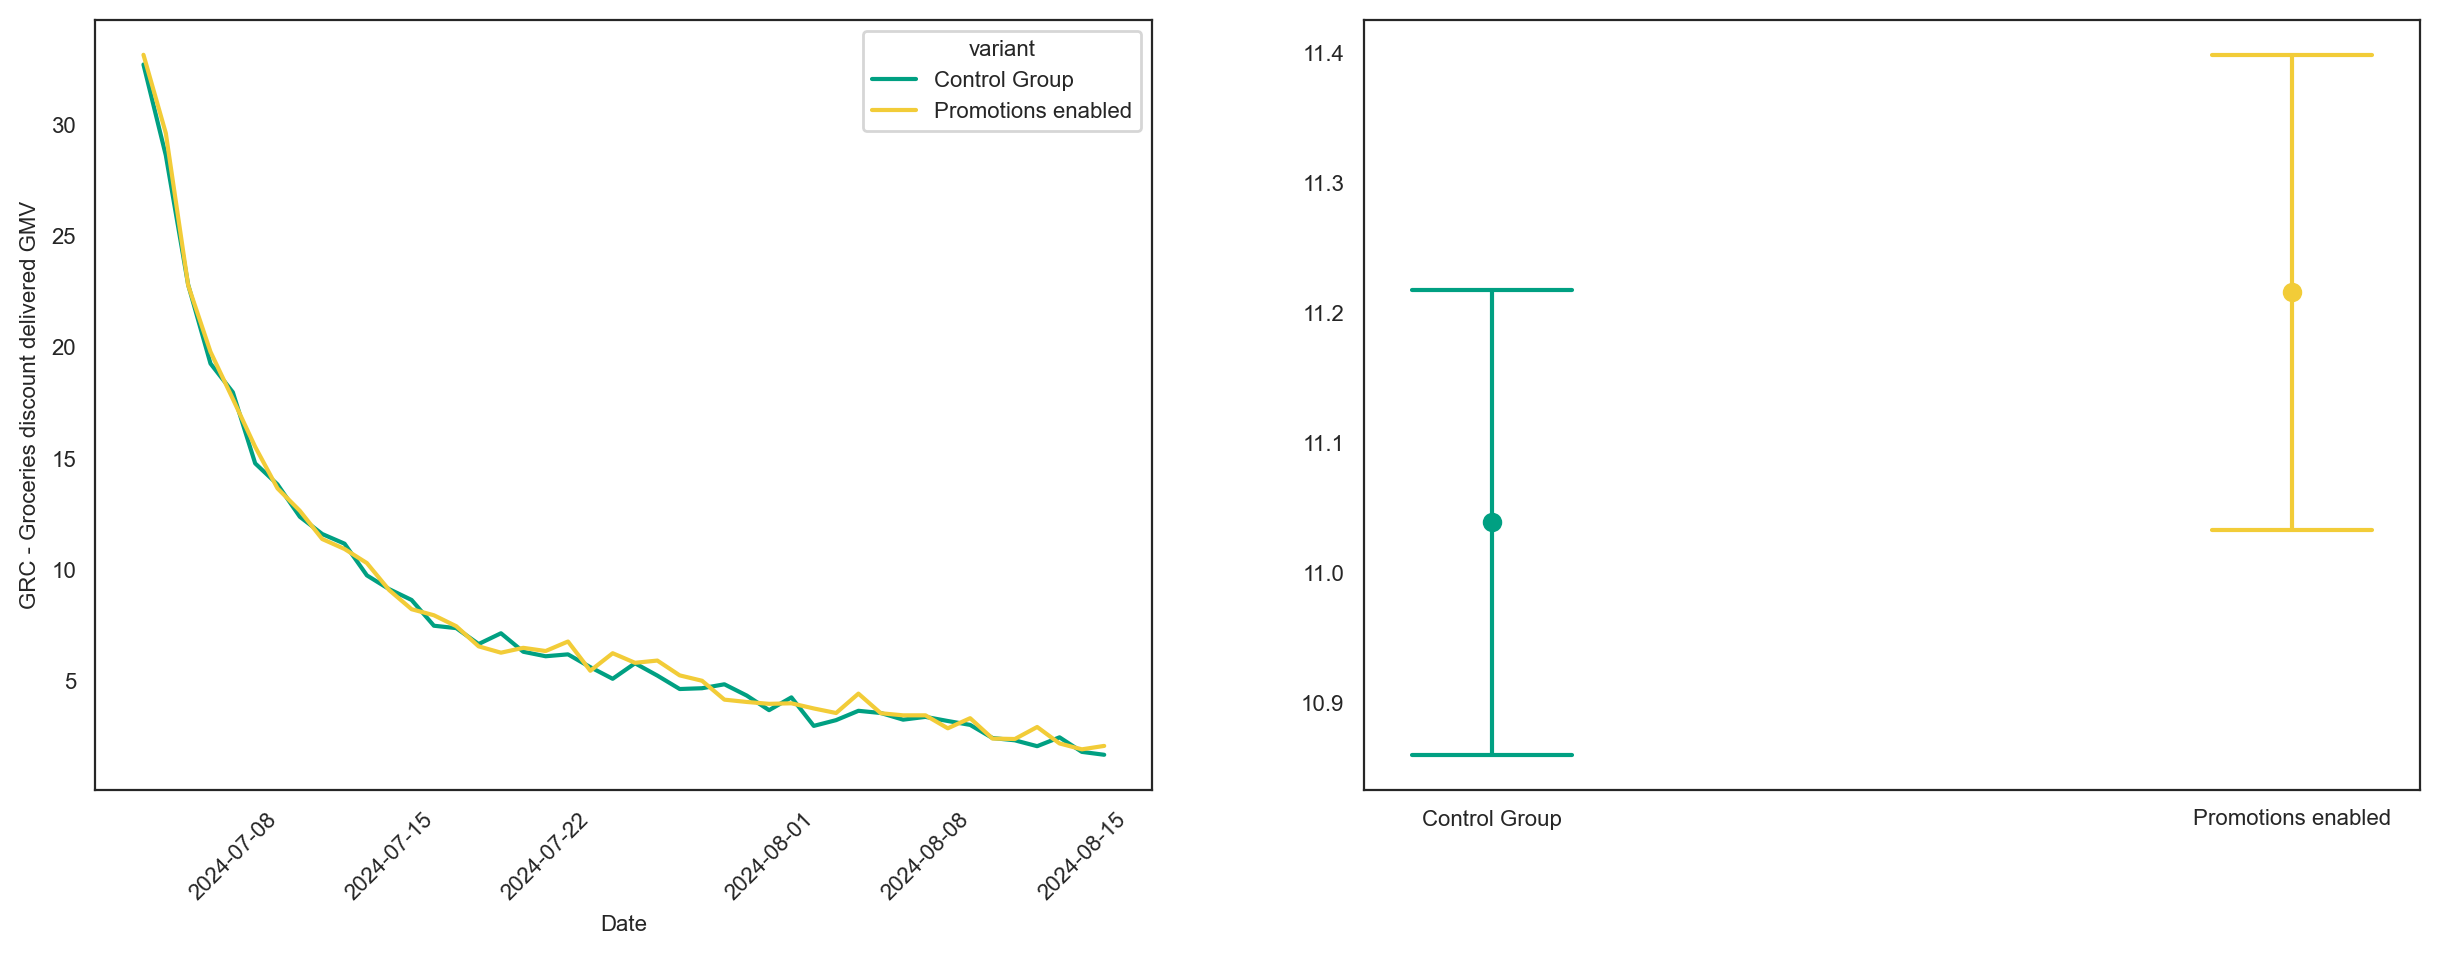

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GNC - GROCERIES DISCOUNT DELIVERED GMV                                                                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,1.70734,1.70591,-0.00143,-0.09577,0.09290,0.96970,0.03777,False


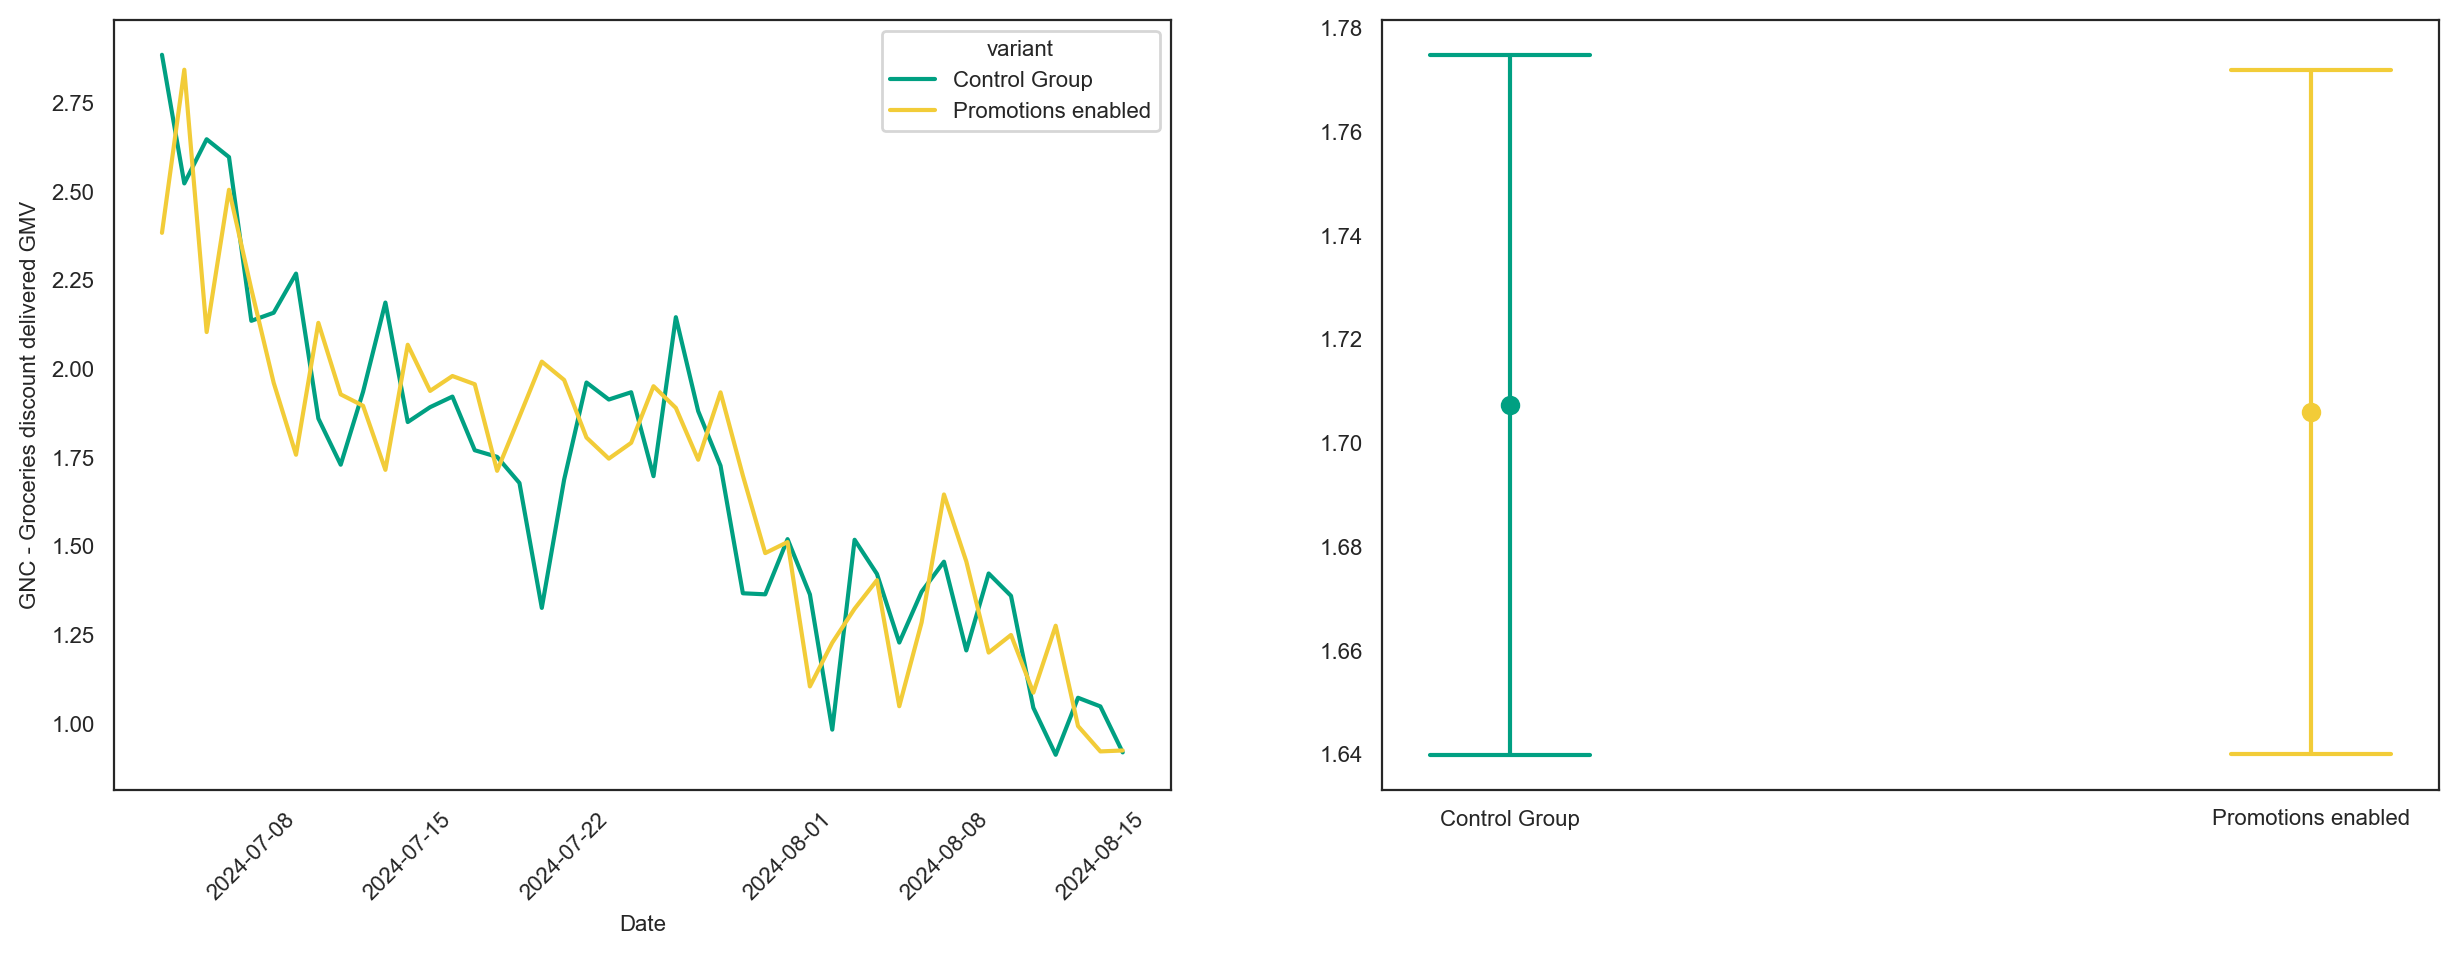

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GRC - GROCERIES DELIVERED GMV                                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,41.82210,41.70421,-0.11789,-0.58631,0.35053,0.52960,0.18754,False


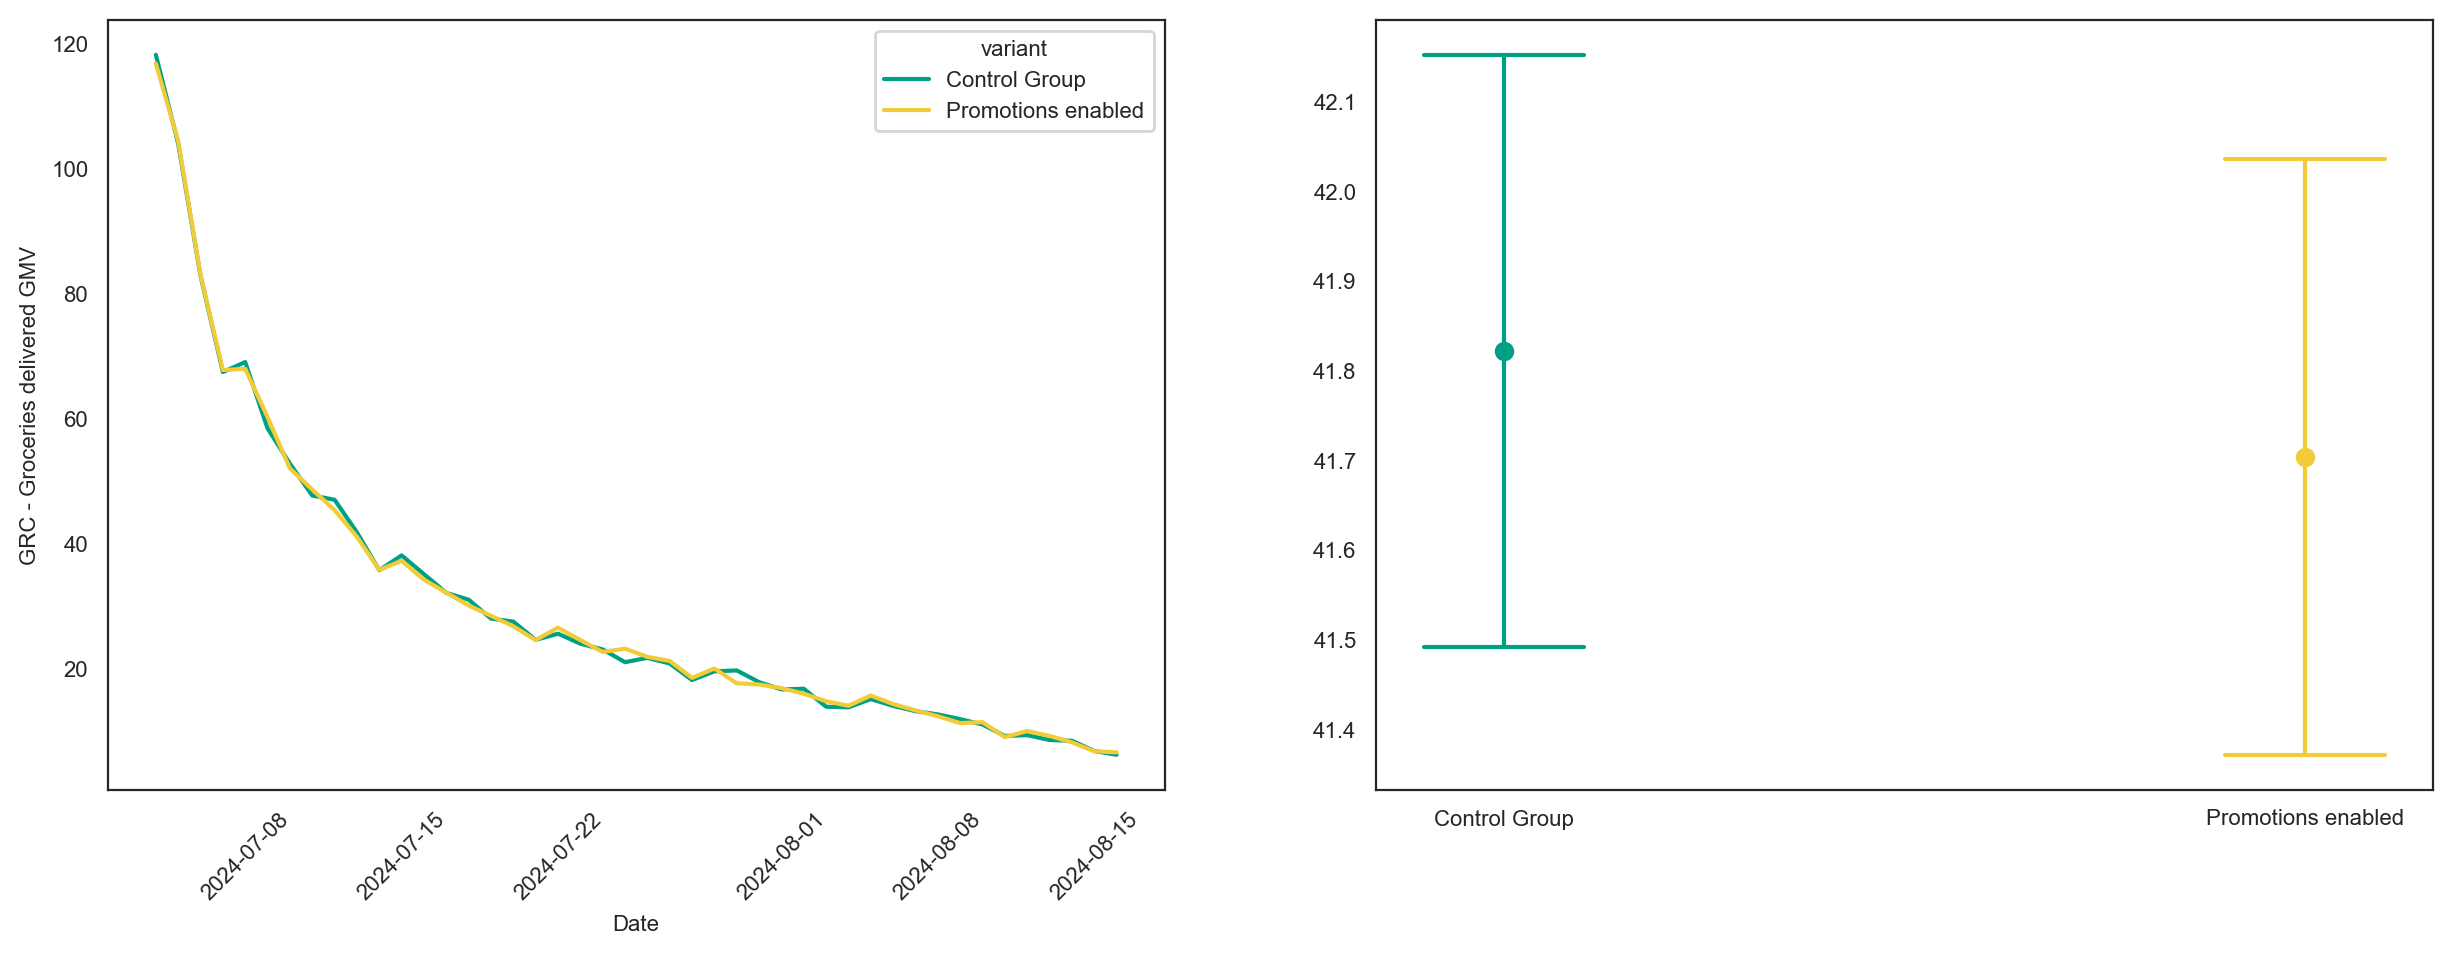

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GNC - GROCERIES DELIVERED GMV                                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,5.37121,5.34845,-0.02276,-0.16600,0.12048,0.69147,0.05735,False


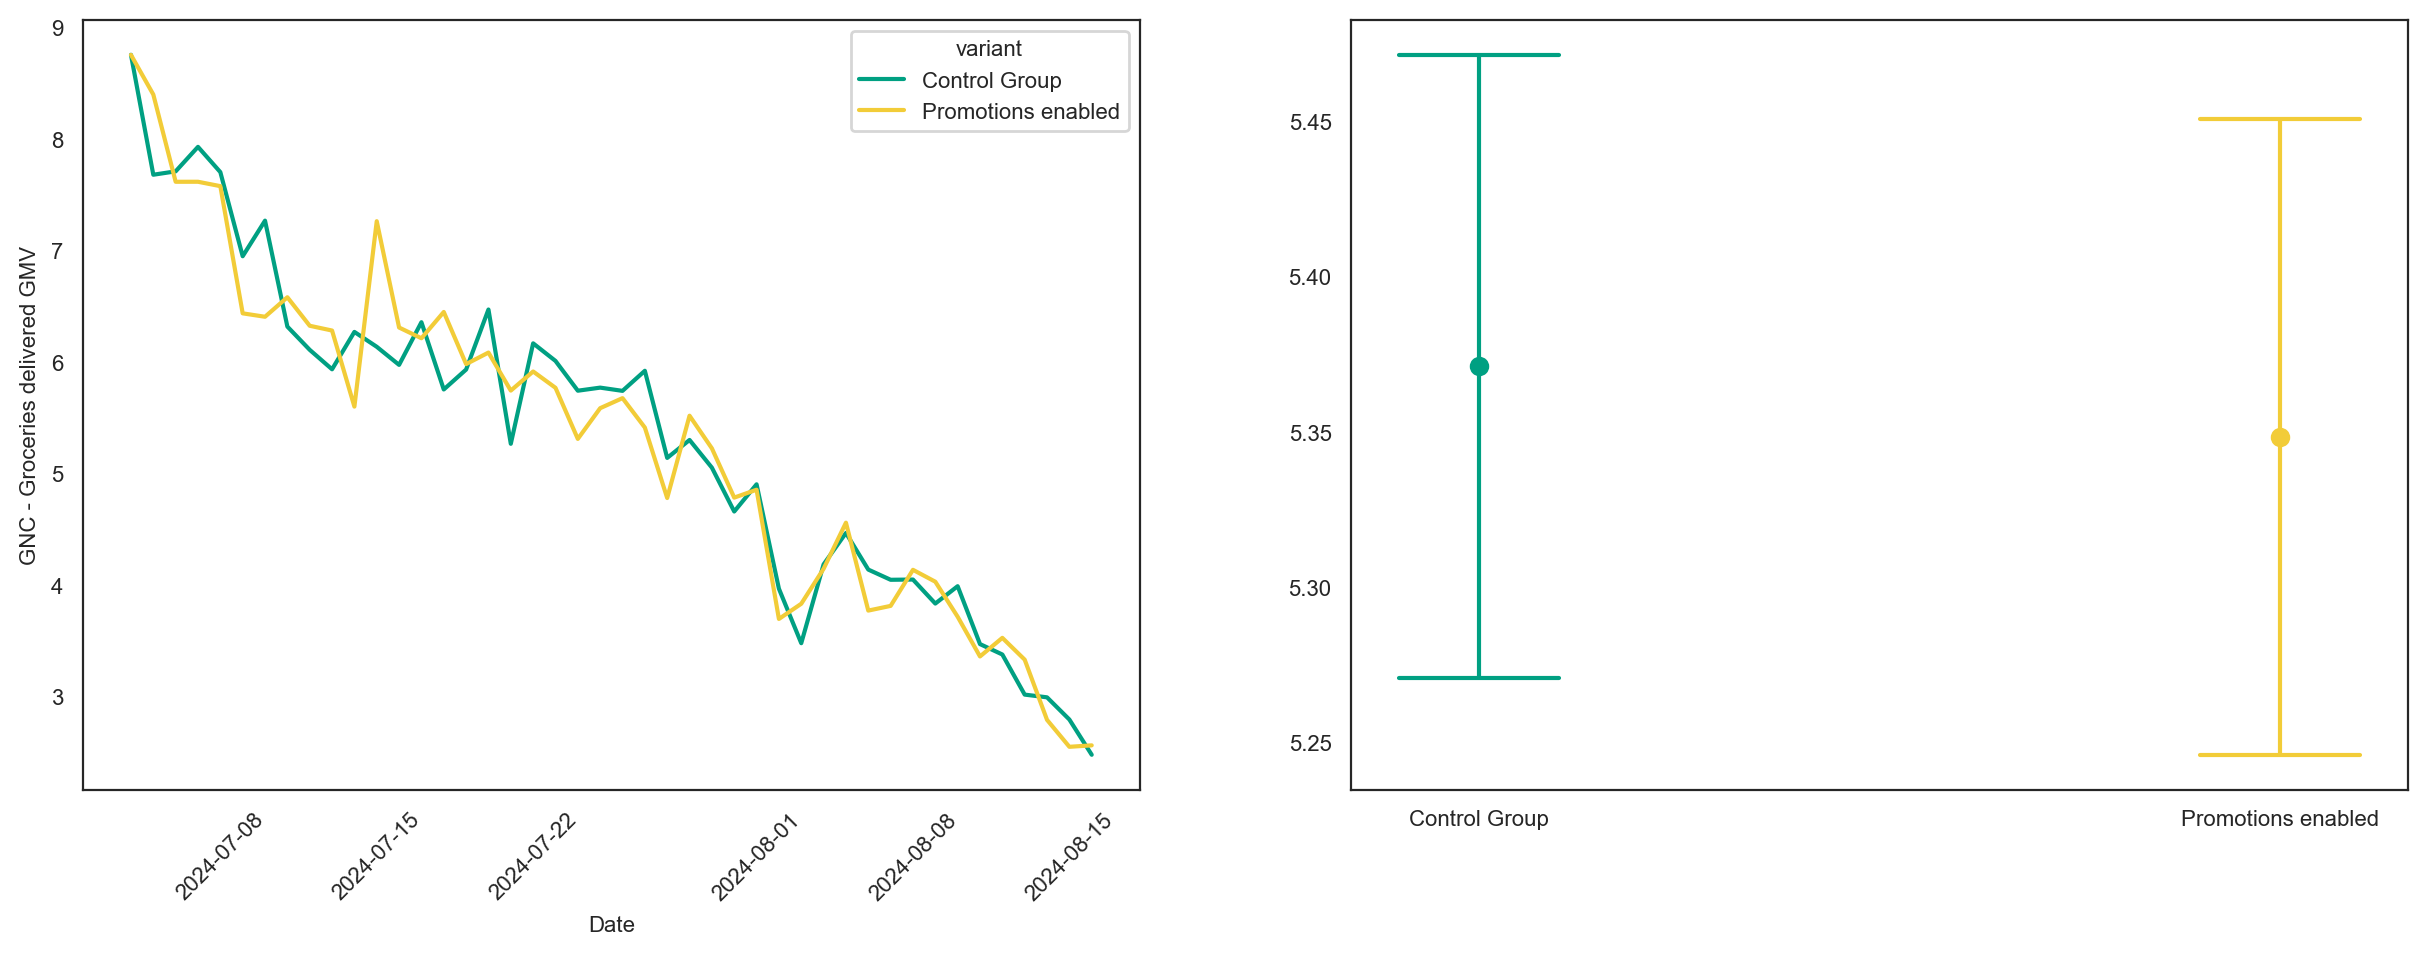

In [62]:
### Orders and GMV by GRC/GNC

experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "",
        "start_date": "2024-07-04",
        "end_date": "2024-08-16",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "GRC - Groceries discount delivered GMV",
                "df": df_customers_exp.query('is_recurrent_groceries == 1'),
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_disc_gmv_eur",
            },
            {
                "metric_name": "GNC - Groceries discount delivered GMV",
                "df": df_customers_exp.query('is_recurrent_groceries == 0'),
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_disc_gmv_eur",
            },  
            {
                "metric_name": "GRC - Groceries delivered GMV",
                "df": df_customers_exp.query('is_recurrent_groceries == 1'),
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_gmv_eur",
            },  
            {
                "metric_name": "GNC - Groceries delivered GMV",
                "df": df_customers_exp.query('is_recurrent_groceries == 0'),
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_gmv_eur",
            },   
            
        ],
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": False
    }

exp_fin_type = Experiment.from_dict(experiment_config)
exp_fin_type.full_analysis()

In [63]:
### Get scorecard
exp_fin_type_results = pd.DataFrame(exp_fin_type.get_scorecard_summary())
exp_fin_type_results.to_clipboard()

##### Session level

In [64]:
%%time
### Is faster to download the data into a csv or parquet from Starburst and then load it into a pandas dataframe

df_sessions = pd.read_csv('df_sessions_metrics.csv')
print(df_sessions.shape)

(2189217, 13)
CPU times: user 2.44 s, sys: 589 ms, total: 3.03 s
Wall time: 3.1 s


In [65]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189217 entries, 0 to 2189216
Data columns (total 13 columns):
 #   Column                                      Dtype 
---  ------                                      ----- 
 0   customer_id                                 int64 
 1   first_exposure_date                         object
 2   variant                                     object
 3   is_recurrent_groceries                      object
 4   total_sessions                              int64 
 5   sessions_store_access                       int64 
 6   sessions_store_access_groceries             int64 
 7   sessions_store_access_groceries_promo       int64 
 8   sessions_chk_loaded                         int64 
 9   sessions_chk_loaded_groceries               int64 
 10  sessions_order_created                      int64 
 11  sessions_order_created_groceries            int64 
 12  sessions_promotion_order_created_groceries  int64 
dtypes: int64(10), object(3)
memory usage: 217.

In [67]:
check_duplicates(df_sessions, 'customer_id')

Success! No duplicates


In [69]:
df_sessions.describe()

,customer_id,total_sessions,sessions_store_access,sessions_store_access_groceries,sessions_store_access_groceries_promo,sessions_chk_loaded,sessions_chk_loaded_groceries,sessions_order_created,sessions_order_created_groceries,sessions_promotion_order_created_groceries
count,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000
mean,99085682.92856,9.05009,5.80056,2.81020,2.45620,3.46396,1.24852,2.92967,1.03932,0.08907
std,61337923.24528,11.54631,7.64690,4.18241,3.48885,5.69451,2.86744,5.34396,2.65505,0.72100
min,220.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,38660178.00000,2.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000
50%,118328249.00000,5.00000,3.00000,1.00000,1.00000,2.00000,0.00000,1.00000,0.00000,0.00000
75%,157731047.00000,11.00000,7.00000,3.00000,2.00000,4.00000,1.00000,3.00000,1.00000,0.00000
max,175620929.00000,381.00000,362.00000,233.00000,233.00000,233.00000,231.00000,138.00000,114.00000,114.00000


In [71]:
## Check split of customers with sessions store access promotions by groups

df_sessions.groupby('variant')[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df_sessions['customer_id'].nunique())

,customer_id,perc
,nunique,
variant,,
Control Group,1095399,0.50036
Promotions enabled,1093818,0.49964


In [72]:
df_sessions.variant.unique()

array(['Promotions enabled', 'Control Group'], dtype=object)

In [73]:
## Check split of sessions by groups

df_sessions.groupby('variant')[['total_sessions']].agg(['sum']).\
    assign(perc= lambda x: x[('total_sessions','sum')]/df_sessions['total_sessions'].sum())

,total_sessions,perc
,sum,
variant,,
Control Group,9916596,0.50052
Promotions enabled,9896017,0.49948


In [74]:
df_sessions['first_exposure_date'].agg(['min','max'])

min    2024-07-04
max    2024-08-16
Name: first_exposure_date, dtype: object

In [75]:
## Check split of sessions by Groceries recurrent customers

df_sessions.groupby(['is_recurrent_groceries', 'variant'])[['total_sessions']].agg(['sum']).\
    assign(perc= lambda x: x[('total_sessions','sum')]/df_sessions['total_sessions'].sum())

total_sessions    perc
                                                     sum        
is_recurrent_groceries variant                                  
False                  Control Group             2643578 0.13343
                       Promotions enabled        2645536 0.13353
True                   Control Group             7189311 0.36287
                       Promotions enabled        7170005 0.36189

In [76]:
## Check split of sessions by Groceries store access with promotions

df_sessions.groupby(['variant'])[['sessions_store_access_groceries_promo']].agg(['sum']).\
    assign(perc= lambda x: x[('sessions_store_access_groceries_promo','sum')]/df_sessions['sessions_store_access_groceries_promo'].sum())

,sessions_store_access_groceries_promo,perc
,sum,
variant,,
Control Group,2692011,0.50064
Promotions enabled,2685153,0.49936


In [77]:
## Convert dates to datetime format
df_sessions['date'] = pd.to_datetime(df_sessions['first_exposure_date'])

In [78]:
df_sessions.to_csv('df_sessions_clean.csv')
#df_sessions = pd.read_csv('df_sessions_clean.csv')

In [79]:
df_sessions.columns

Index(['customer_id', 'first_exposure_date', 'variant', 'is_recurrent_groceries', 'total_sessions', 'sessions_store_access', 'sessions_store_access_groceries',
       'sessions_store_access_groceries_promo', 'sessions_chk_loaded', 'sessions_chk_loaded_groceries', 'sessions_order_created', 'sessions_order_created_groceries',
       'sessions_promotion_order_created_groceries', 'date'],
      dtype='object')

In [80]:
### Metrics by variant

df_sessions['cvr'] = df_sessions['sessions_order_created'].div(df_sessions['total_sessions'].replace(0,np.NaN))
df_sessions['cvr_groceries'] = df_sessions['sessions_order_created_groceries'].div(df_sessions['sessions_store_access_groceries'].replace(0,np.NaN))
df_sessions['cvr_promo_groceries'] = df_sessions['sessions_promotion_order_created_groceries'].div(df_sessions['sessions_store_access_groceries_promo'].replace(0,np.NaN))

df_sessions.describe()

,customer_id,total_sessions,sessions_store_access,sessions_store_access_groceries,sessions_store_access_groceries_promo,sessions_chk_loaded,sessions_chk_loaded_groceries,sessions_order_created,sessions_order_created_groceries,sessions_promotion_order_created_groceries,date,cvr,cvr_groceries,cvr_promo_groceries
count,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217,2189217.00000,2189217.00000,2189217.00000
mean,99085682.92856,9.05009,5.80056,2.81020,2.45620,3.46396,1.24852,2.92967,1.03932,0.08907,2024-07-21 22:41:58.918133760,0.27997,0.25123,0.01935
min,220.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2024-07-04 00:00:00,0.00000,0.00000,0.00000
25%,38660178.00000,2.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,2024-07-10 00:00:00,0.00000,0.00000,0.00000
50%,118328249.00000,5.00000,3.00000,1.00000,1.00000,2.00000,0.00000,1.00000,0.00000,0.00000,2024-07-20 00:00:00,0.22917,0.00000,0.00000
75%,157731047.00000,11.00000,7.00000,3.00000,2.00000,4.00000,1.00000,3.00000,1.00000,0.00000,2024-08-02 00:00:00,0.50000,0.50000,0.00000
max,175620929.00000,381.00000,362.00000,233.00000,233.00000,233.00000,231.00000,138.00000,114.00000,114.00000,2024-08-16 00:00:00,1.00000,39.00000,3.00000
std,61337923.24528,11.54631,7.64690,4.18241,3.48885,5.69451,2.86744,5.34396,2.65505,0.72100,NaN,0.28788,0.37560,0.11381


In [82]:
### Cap cvr values to 1
df_sessions['cvr'] = df_sessions['cvr'].clip(0,1)
df_sessions['cvr_groceries'] = df_sessions['cvr_groceries'].clip(0,1)
df_sessions['cvr_promo_groceries'] = df_sessions['cvr_promo_groceries'].clip(0,1)

df_sessions.describe()

,customer_id,total_sessions,sessions_store_access,sessions_store_access_groceries,sessions_store_access_groceries_promo,sessions_chk_loaded,sessions_chk_loaded_groceries,sessions_order_created,sessions_order_created_groceries,sessions_promotion_order_created_groceries,date,cvr,cvr_groceries,cvr_promo_groceries
count,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217.00000,2189217,2189217.00000,2189217.00000,2189217.00000
mean,99085682.92856,9.05009,5.80056,2.81020,2.45620,3.46396,1.24852,2.92967,1.03932,0.08907,2024-07-21 22:41:58.918133760,0.27997,0.25035,0.01934
min,220.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2024-07-04 00:00:00,0.00000,0.00000,0.00000
25%,38660178.00000,2.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,2024-07-10 00:00:00,0.00000,0.00000,0.00000
50%,118328249.00000,5.00000,3.00000,1.00000,1.00000,2.00000,0.00000,1.00000,0.00000,0.00000,2024-07-20 00:00:00,0.22917,0.00000,0.00000
75%,157731047.00000,11.00000,7.00000,3.00000,2.00000,4.00000,1.00000,3.00000,1.00000,0.00000,2024-08-02 00:00:00,0.50000,0.50000,0.00000
max,175620929.00000,381.00000,362.00000,233.00000,233.00000,233.00000,231.00000,138.00000,114.00000,114.00000,2024-08-16 00:00:00,1.00000,1.00000,1.00000
std,61337923.24528,11.54631,7.64690,4.18241,3.48885,5.69451,2.86744,5.34396,2.65505,0.72100,NaN,0.28788,0.37097,0.11376


                                              Experiment Information                                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃               ┃            ┃               ┃               ┃               ┃             ┃       ┃        Alpha ┃
┃ Name          ┃ Hypothesis ┃          Date ┃       Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing     │            │ 2024-07-04 to │       ['CVR', │     ['Control │       False │  0.05 │       0.0167 │
│ promos for    │            │    2024-08-16 │    'Groceries │       Group', │             │       │              │
│ Groceries     │            │               │         CVR', │   'Promotions │             │       │              │
│               │            │               │   'Promotions │     enabled'] │             │       │              │
│               │            │               │     Groceries │               │             │       │              │
│               │            │               │         CVR'] │               │             │       │              │
└───────────────┴────────────┴───────────────┴───────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ CVR                                                                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.28021,0.27973,-0.00048,-0.00141,0.00045,0.21875,0.00039,False


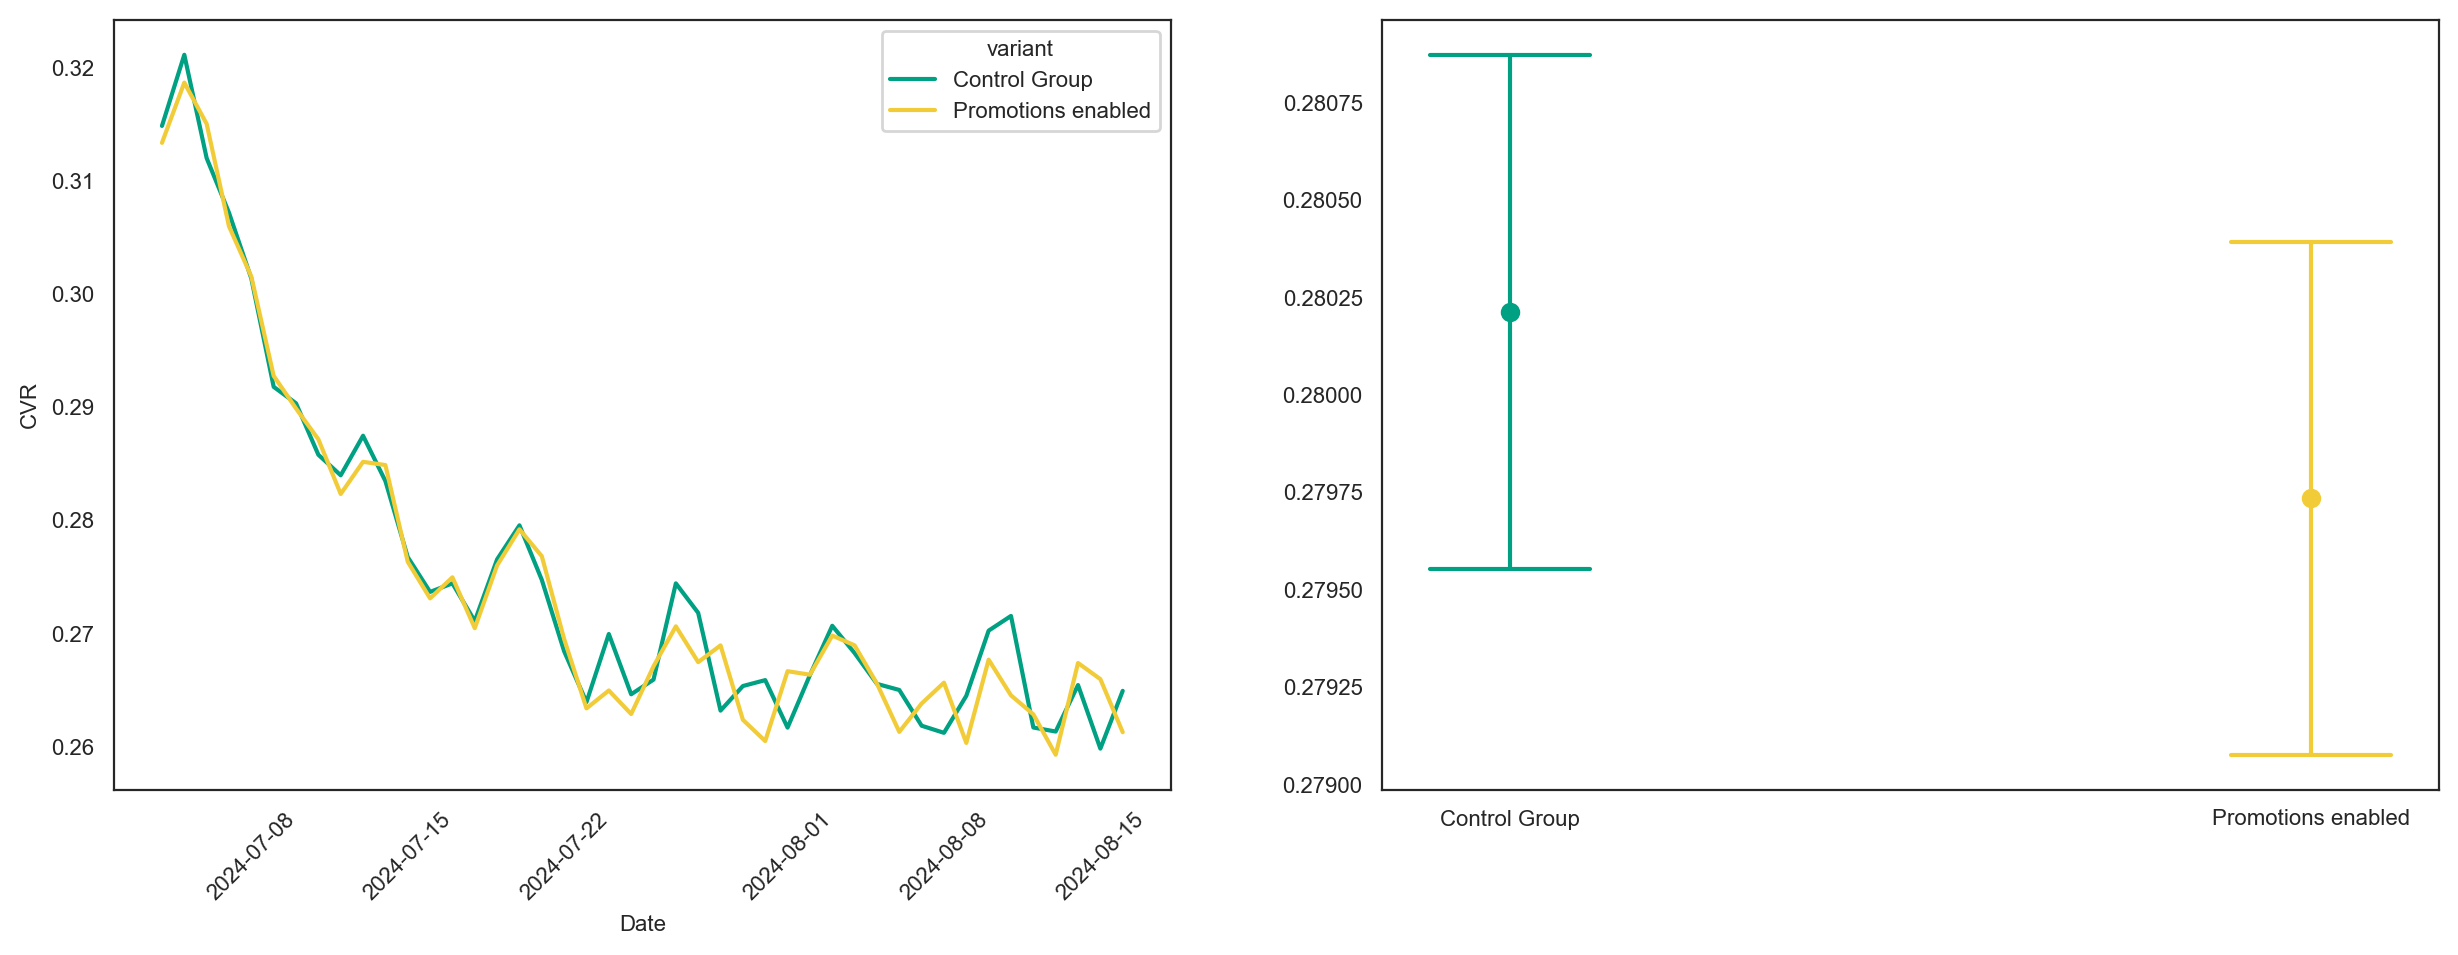

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES CVR                                                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.25088,0.24981,-0.00108,-0.00228,0.00012,0.03176,0.00050,False


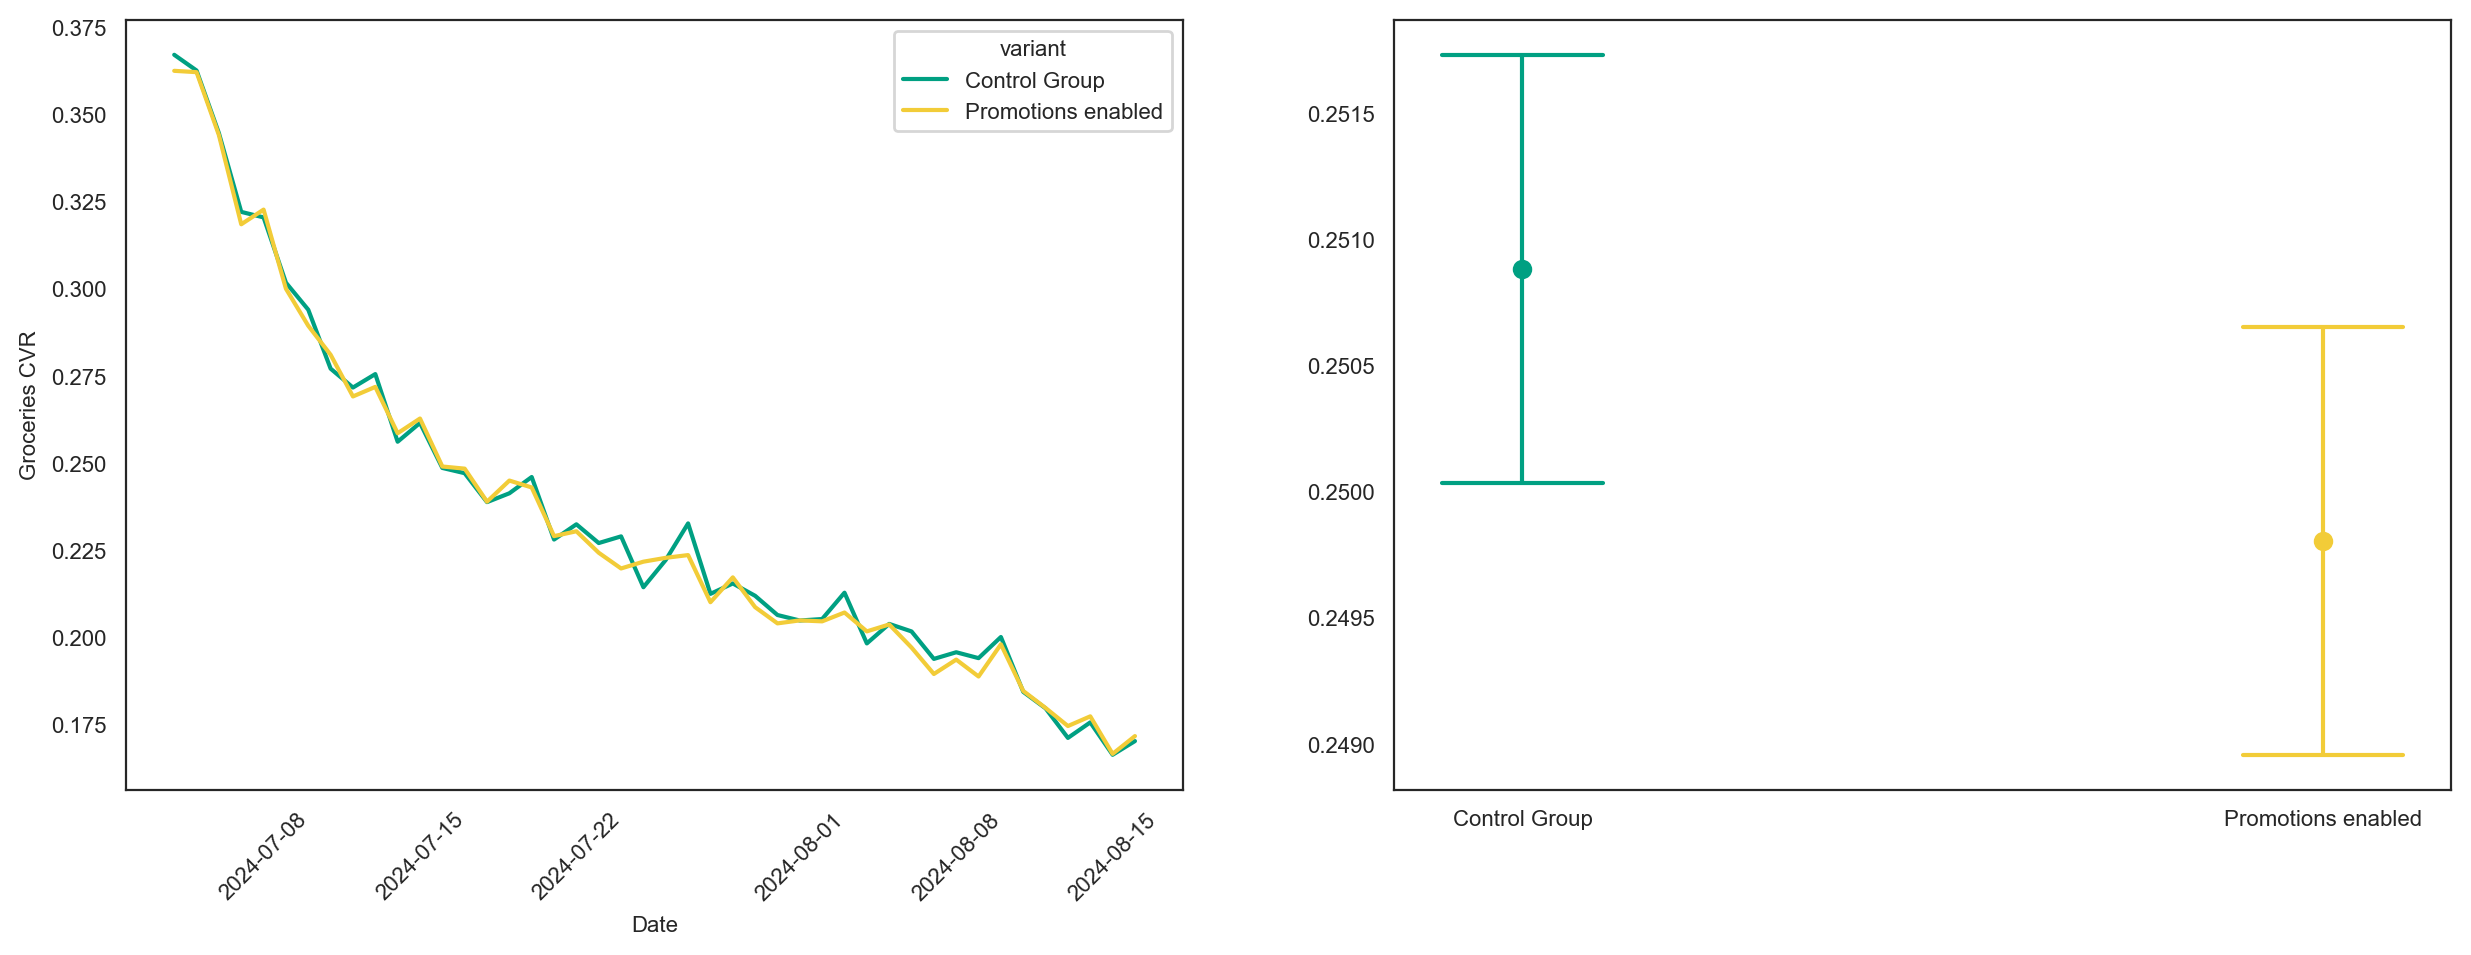

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ PROMOTIONS GROCERIES CVR                                                                                        │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.01948,0.01921,-0.00028,-0.00064,0.00009,0.07329,0.00015,False


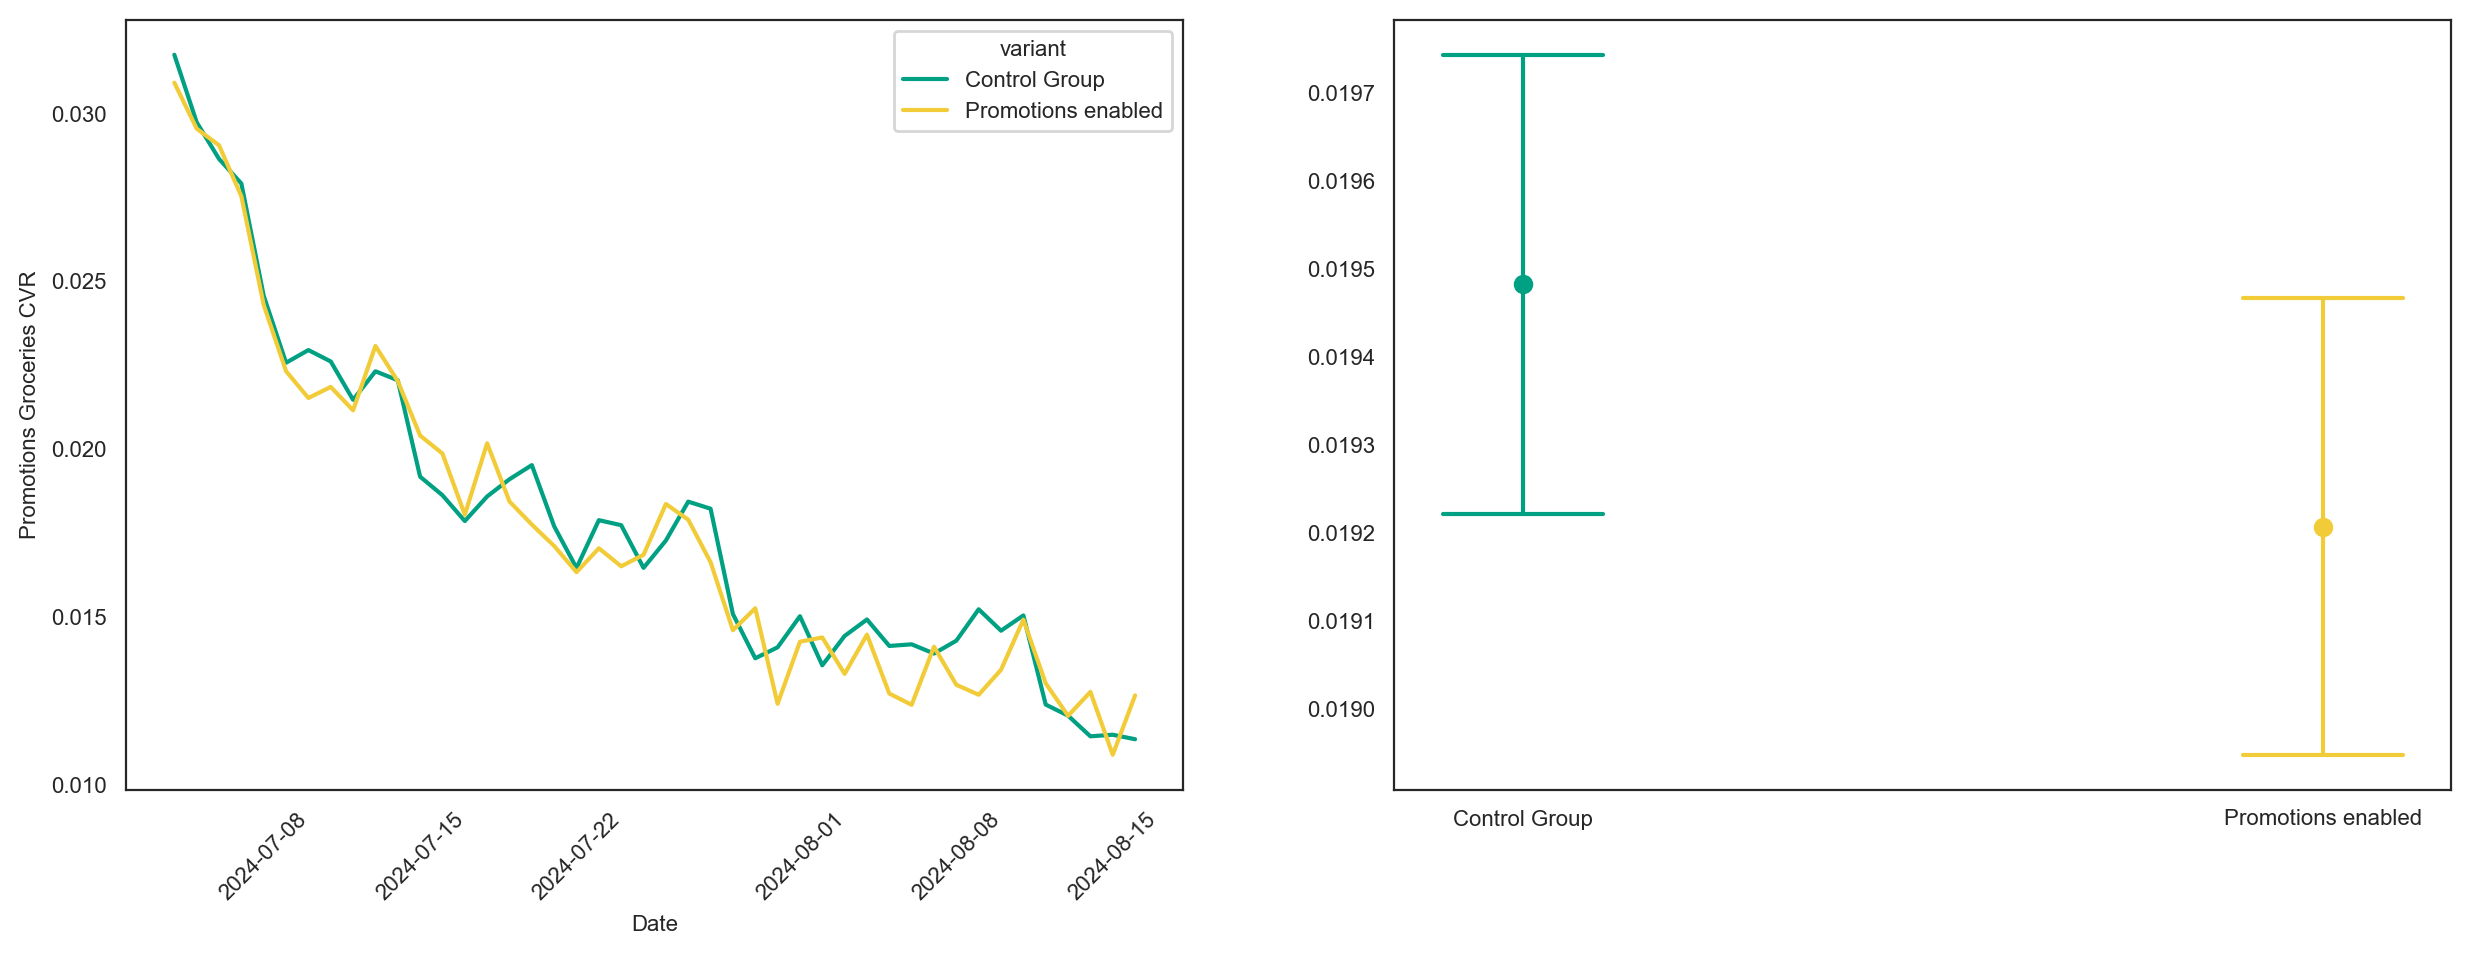

In [83]:
### Groceries CVR

from glovo_experimentation_analytics.analytics.experiment import Experiment

experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "",
        "start_date": "2024-07-04",
        "end_date": "2024-08-16",
        "treatment_col": "variant",
        "metrics": [
            {
               "metric_name": "CVR",
                "df": df_sessions,
                "analysis_type": "clustered_ols",
                "cluster_cols" : ["customer_id"],
                "metric_col": "cvr",
            },
            {
                "metric_name": "Groceries CVR",
                "df": df_sessions,
                "analysis_type": "clustered_ols",
                "cluster_cols" : ["customer_id"],
                "metric_col": "cvr_groceries",
            },
            {
               "metric_name": "Promotions Groceries CVR",
                "df": df_sessions,
                "analysis_type": "clustered_ols",
                "cluster_cols" : ["customer_id"],
                "metric_col": "cvr_promo_groceries",
            }
        ],
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": False
    }

exp_main = Experiment.from_dict(experiment_config)
exp_main.full_analysis()

In [84]:
### Get Experiment Scorecard
exp_main_results = pd.DataFrame(exp_main.get_scorecard_summary())
exp_main_results.to_clipboard()

                                              Experiment Information                                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃               ┃            ┃               ┃               ┃               ┃             ┃       ┃        Alpha ┃
┃ Name          ┃ Hypothesis ┃          Date ┃       Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing     │            │ 2024-07-04 to │       ['GRC - │     ['Control │       False │  0.05 │       0.0250 │
│ promos for    │            │    2024-08-16 │    Promotions │       Group', │             │       │              │
│ Groceries     │            │               │     Groceries │   'Promotions │             │       │              │
│               │            │               │  CVR', 'GNC - │     enabled'] │             │       │              │
│               │            │               │    Promotions │               │             │       │              │
│               │            │               │     Groceries │               │             │       │              │
│               │            │               │         CVR'] │               │             │       │              │
└───────────────┴────────────┴───────────────┴───────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GRC - PROMOTIONS GROCERIES CVR                                                                                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.02849,0.02796,-0.00053,-0.00108,0.00001,0.02914,0.00024,False


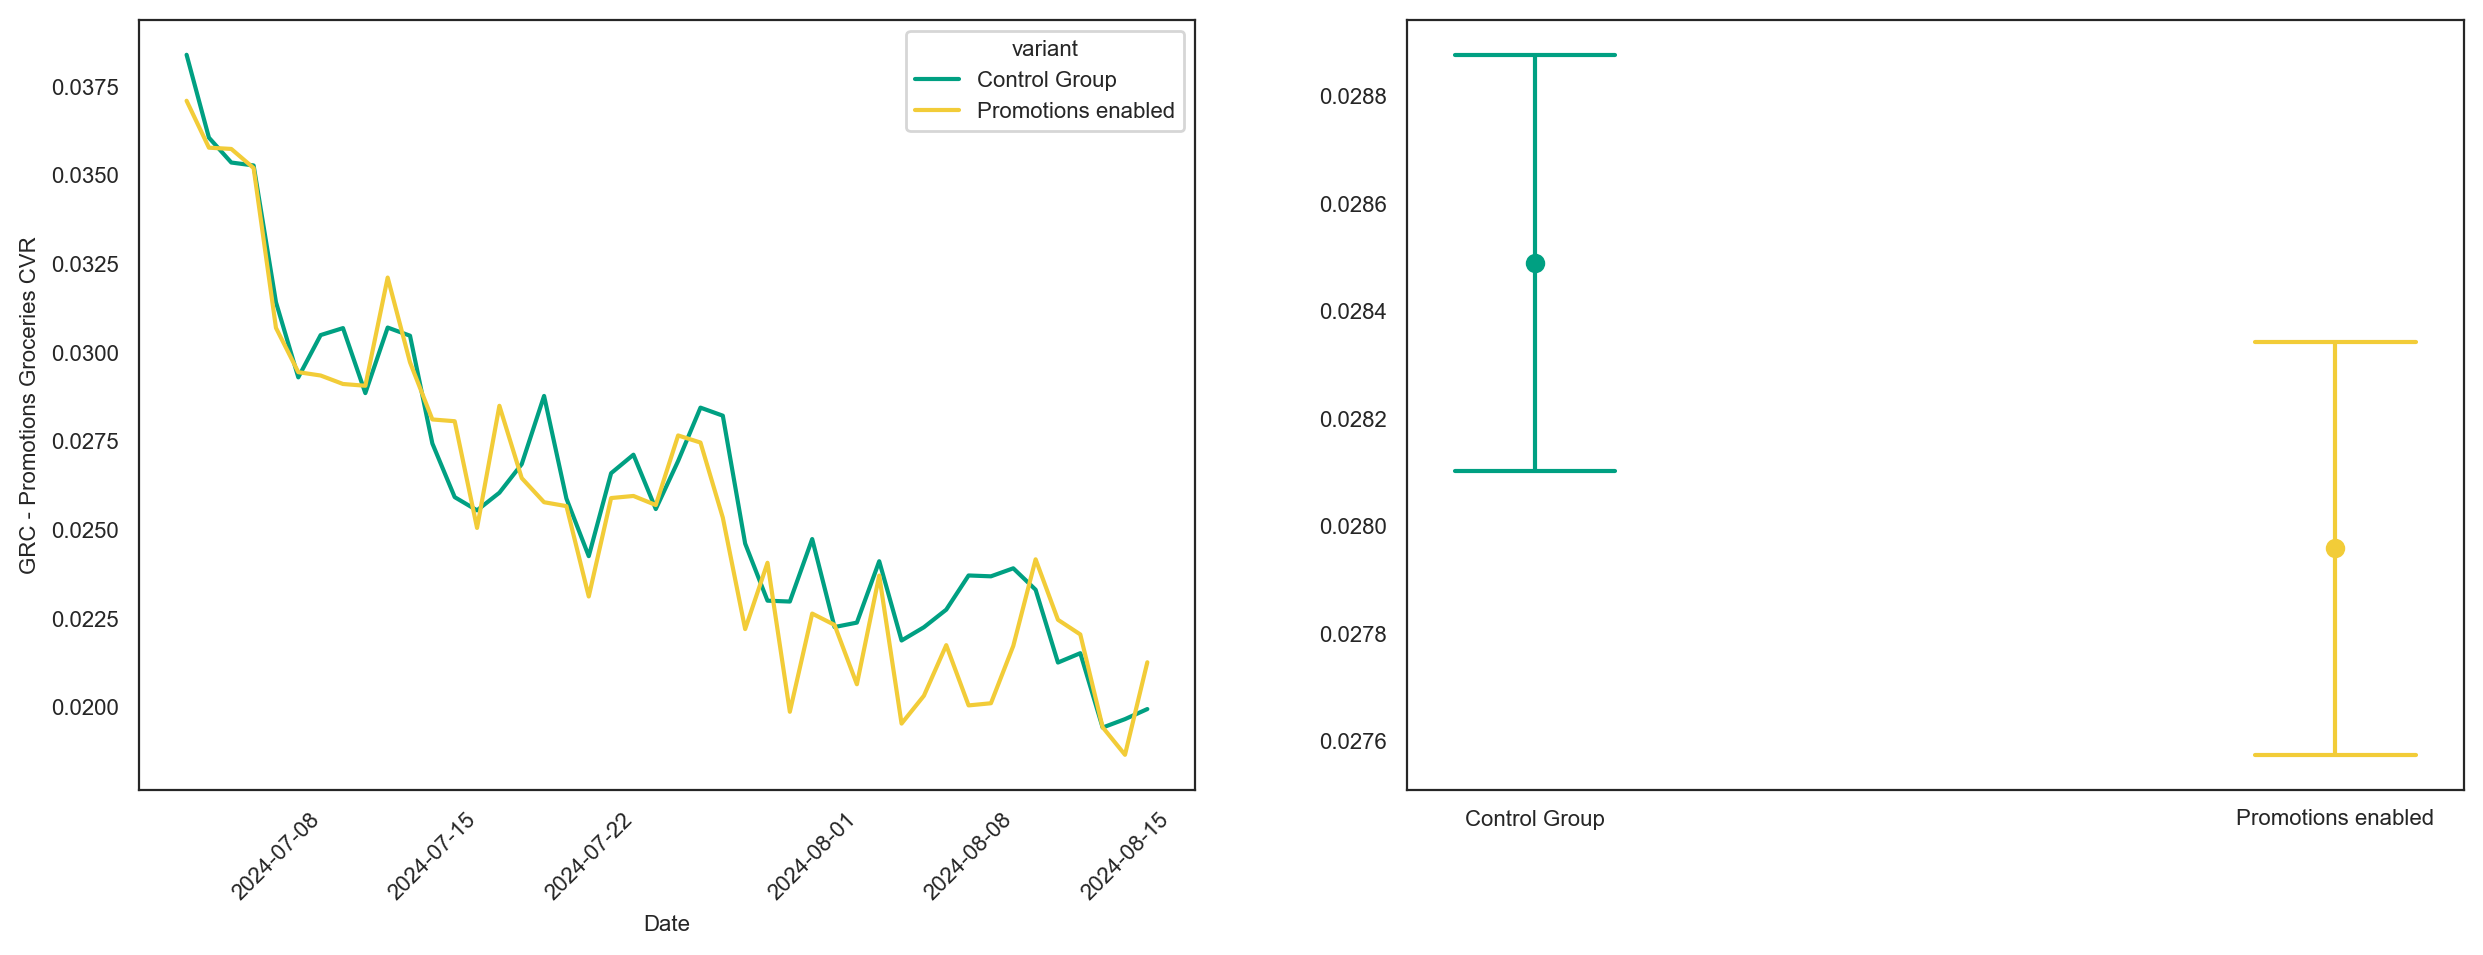

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GNC - PROMOTIONS GROCERIES CVR                                                                                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.00742,0.00750,0.00009,-0.00025,0.00043,0.56162,0.00015,False


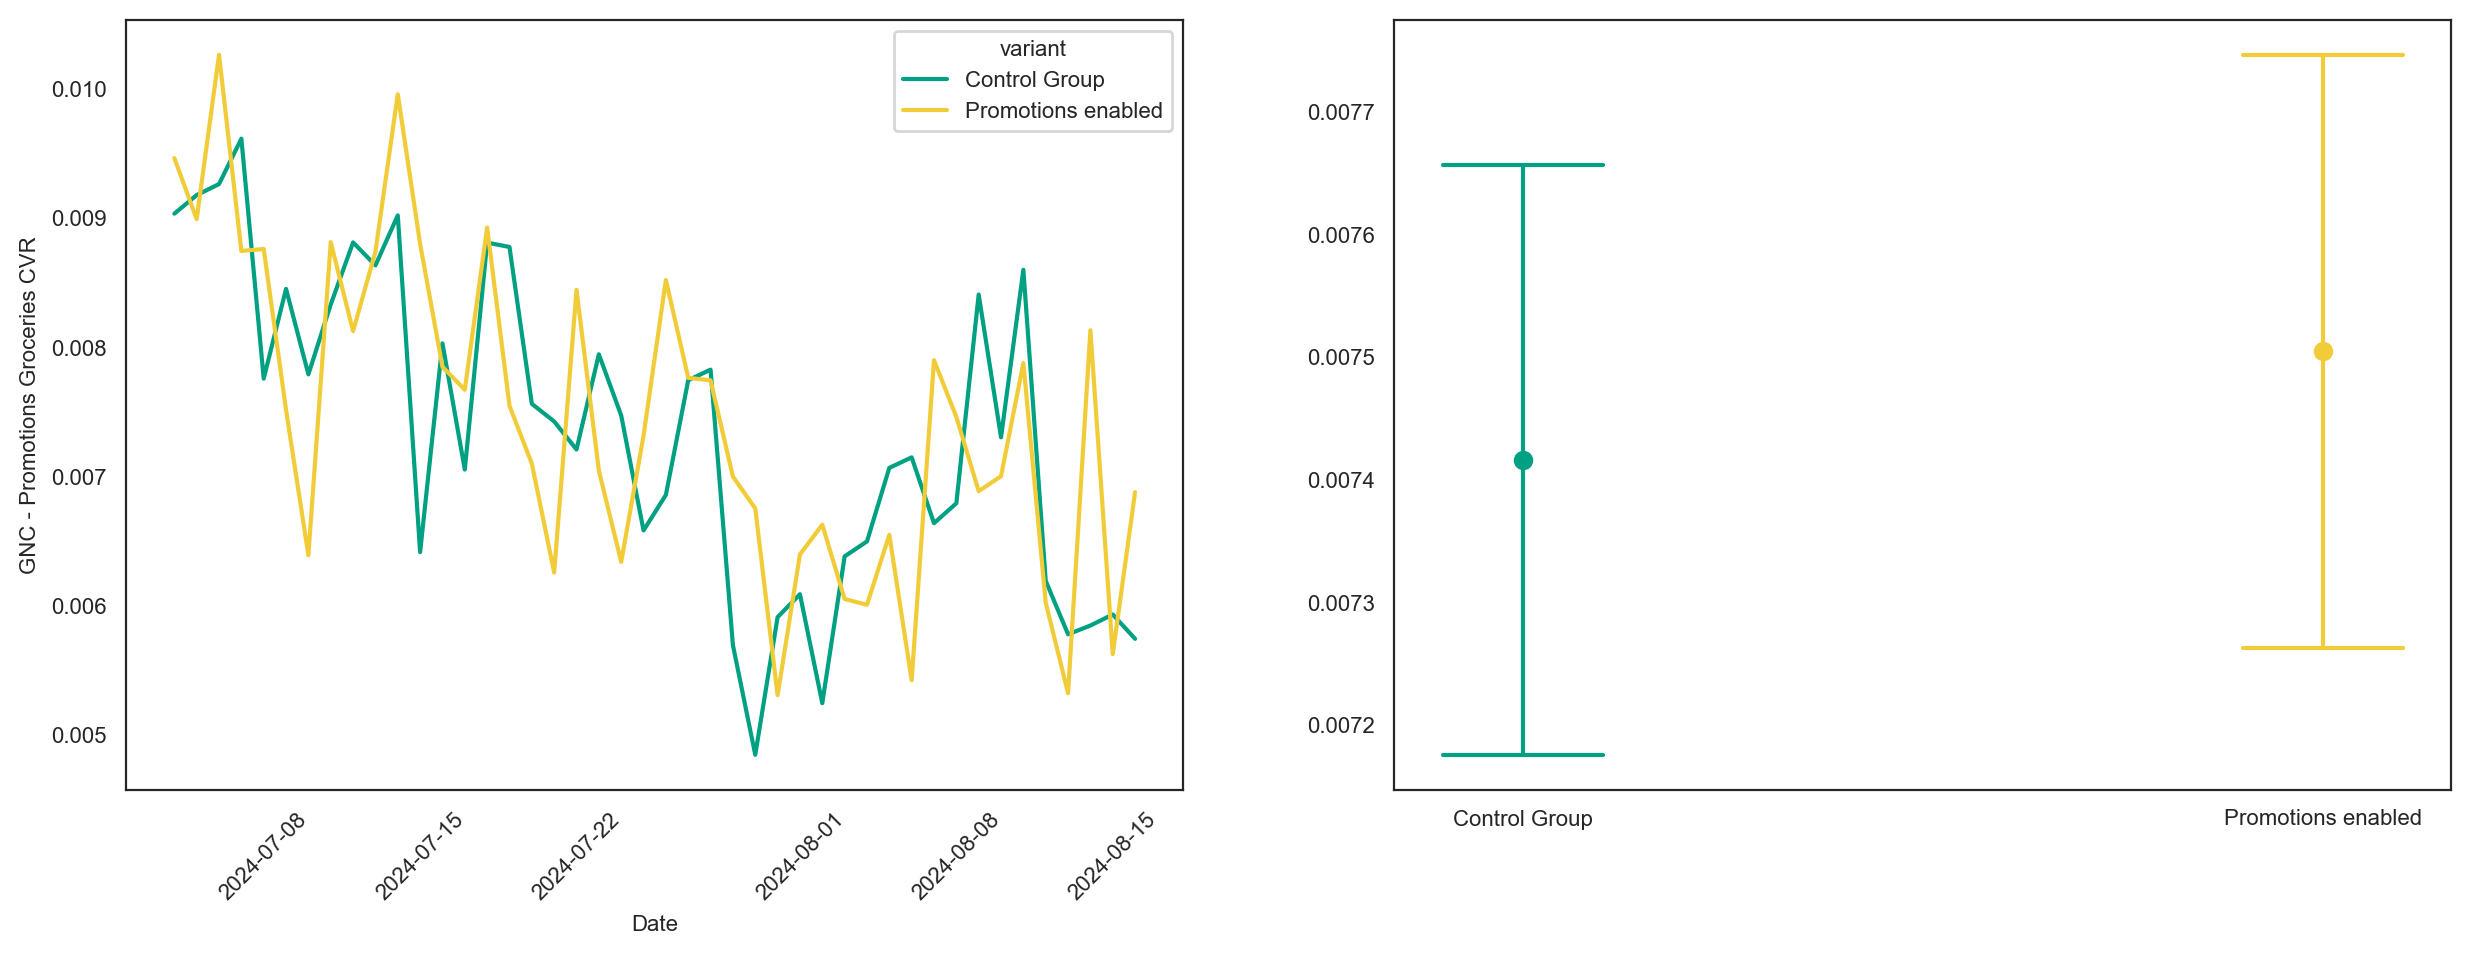

In [85]:
### Groceries CVR by GRC/GNC

experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "",
        "start_date": "2024-07-04",
        "end_date": "2024-08-16",
        "treatment_col": "variant",
        "metrics": [
            {
               "metric_name": "GRC - Promotions Groceries CVR",
                "df": df_sessions.query('(is_recurrent_groceries == 1)'),
                "analysis_type": "clustered_ols",
                "cluster_cols" : ["customer_id"],
                "metric_col": "cvr_promo_groceries",
            },
             {
               "metric_name": "GNC - Promotions Groceries CVR",
                "df": df_sessions.query('(is_recurrent_groceries == 0)'),
                "analysis_type": "clustered_ols",
                "cluster_cols" : ["customer_id"],
                "metric_col": "cvr_promo_groceries",
            }
        ],
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": False
    }

exp_main_cohorts = Experiment.from_dict(experiment_config)
exp_main_cohorts.full_analysis()

In [86]:
### Get Experiment Scorecard
exp_main_cohorts_results = pd.DataFrame(exp_main_cohorts.get_scorecard_summary())
exp_main_cohorts_results.to_clipboard()

##### Order level

In [87]:
%%time
### Is faster to download the data into a csv or parquet from Starburst and then load it into a pandas dataframe

df_orders = pd.read_csv('df_orders_metrics.csv')
print(df_orders.shape)

(2555664, 18)
CPU times: user 4.56 s, sys: 1.14 s, total: 5.7 s
Wall time: 6.07 s


In [88]:
df_orders.columns

Index(['customer_id', 'variant', 'first_exposure_date', 'is_recurrent_groceries', 'total_orders', 'groceries_orders', 'groceries_orders_with_promo', 'total_orders_with_promo',
       'total_effective_purchase_eur', 'groceries_total_effective_purchase_eur', 'groceries_promo_total_effective_purchase_eur', 'total_purchase_eur', 'groceries_total_purchase_eur',
       'groceries_promo_total_purchase_eur', 'total_distinct_items', 'total_items', 'total_discounted_items', 'next_delivered_orders_28_days'],
      dtype='object')

In [89]:
check_duplicates(df_orders, 'customer_id')

Success! No duplicates


In [90]:
df_orders.describe()

,customer_id,total_orders,groceries_orders,groceries_orders_with_promo,total_orders_with_promo,total_effective_purchase_eur,groceries_total_effective_purchase_eur,groceries_promo_total_effective_purchase_eur,total_purchase_eur,groceries_total_purchase_eur,groceries_promo_total_purchase_eur,total_distinct_items,total_items,total_discounted_items,next_delivered_orders_28_days
count,2555664.00000,2555664.00000,2555664.00000,2555664.00000,2555664.00000,1844258.00000,2555664.00000,2555664.00000,1844258.00000,2555664.00000,2555664.00000,1844258.00000,1842296.00000,1844258.00000,2555664.00000
mean,99179174.54849,3.82788,1.22653,0.17630,0.67817,86.90690,22.23475,3.64191,91.07803,22.65986,3.86191,20.79964,29.37460,2.54975,3.16583
std,61224955.59215,7.20574,3.42481,0.88623,1.71734,162.43197,72.01241,19.95854,167.62590,73.21557,21.26752,38.90781,65.49954,8.71108,7.02096
min,220.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
25%,39237955.75000,0.00000,0.00000,0.00000,0.00000,15.88829,0.00000,0.00000,16.80030,0.00000,0.00000,3.00000,4.00000,0.00000,0.00000
50%,118439073.50000,1.00000,0.00000,0.00000,0.00000,37.02516,0.00000,0.00000,39.24000,0.00000,0.00000,8.00000,10.00000,0.00000,0.00000
75%,157535539.75000,4.00000,1.00000,0.00000,1.00000,93.12000,15.35000,0.00000,98.06000,15.70000,0.00000,21.00000,27.00000,2.00000,3.00000
max,175620984.00000,1118.00000,1118.00000,556.00000,556.00000,74686.64408,6947.26254,2593.29013,74686.64408,6954.29773,4384.19235,1665.00000,17141.00000,846.00000,1116.00000


In [92]:
### Groceries orders
df_orders.groupby('variant').agg({
    'total_items':'mean',
    'total_distinct_items':'mean',
    'total_discounted_items':'mean',
    'groceries_total_purchase_eur':'mean',
    'groceries_promo_total_effective_purchase_eur':'mean'
})

,total_items,total_distinct_items,total_discounted_items,groceries_total_purchase_eur,groceries_promo_total_effective_purchase_eur
variant,,,,,
Control Group,29.42687,20.84329,2.54936,22.78549,3.66815
Promotions enabled,29.32232,20.75599,2.55014,22.53419,3.61567


In [93]:
df_orders.head()

,customer_id,variant,first_exposure_date,is_recurrent_groceries,total_orders,groceries_orders,groceries_orders_with_promo,total_orders_with_promo,total_effective_purchase_eur,groceries_total_effective_purchase_eur,groceries_promo_total_effective_purchase_eur,total_purchase_eur,groceries_total_purchase_eur,groceries_promo_total_purchase_eur,total_distinct_items,total_items,total_discounted_items,next_delivered_orders_28_days
0,115508716,Control Group,2024-07-17,True,5,1,1,4,95.46000,19.50000,19.50000,96.40000,19.50000,19.50000,13.00000,13.00000,0.00000,4
1,161808197,Control Group,2024-08-10,False,1,0,0,0,23.50000,0.00000,0.00000,23.50000,0.00000,0.00000,5.00000,7.00000,0.00000,0
2,38369037,Control Group,2024-08-04,True,0,0,0,0,NaN,0.00000,0.00000,NaN,0.00000,0.00000,NaN,NaN,NaN,0
3,142499956,Control Group,2024-07-13,False,0,0,0,0,NaN,0.00000,0.00000,NaN,0.00000,0.00000,NaN,NaN,NaN,0
4,42615083,Control Group,2024-07-31,True,0,0,0,0,NaN,0.00000,0.00000,NaN,0.00000,0.00000,NaN,NaN,NaN,0


In [96]:
round(df_orders[['groceries_promo_total_effective_purchase_eur', 'total_effective_purchase_eur']].describe(percentiles=[0, 0.5,0.95,0.99, 0.999, 0.9999]))

,groceries_promo_total_effective_purchase_eur,total_effective_purchase_eur
count,2555664.00000,1844258.00000
mean,4.00000,87.00000
std,20.00000,162.00000
min,0.00000,0.00000
0%,0.00000,0.00000
50%,0.00000,37.00000
95%,21.00000,332.00000
99%,79.00000,724.00000
99.9%,257.00000,1570.00000
99.99%,564.00000,3029.00000


In [97]:
## Outliers detection

def detect_outliers(df, col):
    # Dictionary to hold outlier indices for each column
    outliers = {}
    clean_df = df.copy()
    
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = 0
    upper_bound = 3000
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    print(f"Number of outliers: {df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]}")
            
    # Create a new df without the outliers
    clean_df = clean_df[(clean_df[col] >= lower_bound) & (clean_df[col] <= upper_bound)]
    
    return clean_df

In [98]:
df_orders_eur_clean = detect_outliers(df_orders, 'total_effective_purchase_eur')
df_orders_eur_clean.describe()

Lower bound: 0, Upper bound: 3000
Number of outliers: 191


,customer_id,total_orders,groceries_orders,groceries_orders_with_promo,total_orders_with_promo,total_effective_purchase_eur,groceries_total_effective_purchase_eur,groceries_promo_total_effective_purchase_eur,total_purchase_eur,groceries_total_purchase_eur,groceries_promo_total_purchase_eur,total_distinct_items,total_items,total_discounted_items,next_delivered_orders_28_days
count,1844067.00000,1844067.00000,1844067.00000,1844067.00000,1844067.00000,1844067.00000,1844067.00000,1844067.00000,1844067.00000,1844067.00000,1844067.00000,1844067.00000,1842105.00000,1844067.00000,1844067.00000
mean,95635801.84472,5.29465,1.69463,0.24361,0.93852,86.46769,30.63754,5.02607,90.63178,31.22507,5.33022,20.74468,29.25936,2.54433,4.37764
std,61218820.54745,7.89887,3.80217,0.94853,1.91233,147.26688,80.45017,23.00540,152.79043,81.83487,24.53210,38.42552,62.88864,8.65420,7.83040
min,220.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
25%,35432790.00000,1.00000,0.00000,0.00000,0.00000,15.88573,0.00000,0.00000,16.80000,0.00000,0.00000,3.00000,4.00000,0.00000,0.00000
50%,111924657.00000,3.00000,1.00000,0.00000,0.00000,37.01745,2.87053,0.00000,39.23000,3.17308,0.00000,8.00000,10.00000,0.00000,2.00000
75%,154271426.50000,6.00000,2.00000,0.00000,1.00000,93.09000,25.56040,0.00000,98.02785,26.17161,0.00000,21.00000,27.00000,2.00000,5.00000
max,175620810.00000,1105.00000,415.00000,200.00000,200.00000,2993.89947,2690.41000,2528.00000,4521.02585,4471.14165,4384.19235,1434.00000,4071.00000,717.00000,1105.00000


In [100]:
### Check outliers

round(df_orders_eur_clean[['groceries_total_effective_purchase_eur', 'groceries_promo_total_effective_purchase_eur']].describe(percentiles=[0, 0.5,0.95,0.99, 0.999, 0.9999]))

,groceries_total_effective_purchase_eur,groceries_promo_total_effective_purchase_eur
count,1844067.00000,1844067.00000
mean,31.00000,5.00000
std,80.00000,23.00000
min,0.00000,0.00000
0%,0.00000,0.00000
50%,3.00000,0.00000
95%,147.00000,29.00000
99%,386.00000,97.00000
99.9%,895.00000,290.00000
99.99%,1559.00000,599.00000


In [101]:
df_orders_clean = df_orders_eur_clean.query('groceries_total_effective_purchase_eur <= 2000')

In [102]:
df_orders_clean.columns

Index(['customer_id', 'variant', 'first_exposure_date', 'is_recurrent_groceries', 'total_orders', 'groceries_orders', 'groceries_orders_with_promo', 'total_orders_with_promo',
       'total_effective_purchase_eur', 'groceries_total_effective_purchase_eur', 'groceries_promo_total_effective_purchase_eur', 'total_purchase_eur', 'groceries_total_purchase_eur',
       'groceries_promo_total_purchase_eur', 'total_distinct_items', 'total_items', 'total_discounted_items', 'next_delivered_orders_28_days'],
      dtype='object')

In [103]:
## Check split of orders by Groceries type of customers

df_orders_clean.groupby(['is_recurrent_groceries', 'variant'])[['total_orders']].agg(['sum']).\
    assign(perc= lambda x: x[('total_orders','sum')]/df_orders_clean['total_orders'].sum())

total_orders    perc
                                                   sum        
is_recurrent_groceries variant                                
False                  Control Group           1002196 0.10268
                       Promotions enabled      1002640 0.10273
True                   Control Group           3818306 0.39120
                       Promotions enabled      3812295 0.39059

In [104]:
## Check split of customers by Groceries type of customers

df_orders_clean.groupby(['is_recurrent_groceries', 'variant'])[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df_orders_clean['customer_id'].nunique())

customer_id    perc
                                              nunique        
is_recurrent_groceries variant                               
False                  Control Group           341347 0.18511
                       Promotions enabled      341783 0.18535
True                   Control Group           569785 0.30899
                       Promotions enabled      569077 0.30861

In [105]:
#df_orders_clean = df_orders_clean.drop(columns=['Unnamed: 0'])
#df_orders_clean.to_csv('df_orders_clean.csv')
#df_orders_clean = pd.read_csv('df_orders_clean.csv')
df_orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1844024 entries, 0 to 2555663
Data columns (total 18 columns):
 #   Column                                        Dtype  
---  ------                                        -----  
 0   customer_id                                   int64  
 1   variant                                       object 
 2   first_exposure_date                           object 
 3   is_recurrent_groceries                        object 
 4   total_orders                                  int64  
 5   groceries_orders                              int64  
 6   groceries_orders_with_promo                   int64  
 7   total_orders_with_promo                       int64  
 8   total_effective_purchase_eur                  float64
 9   groceries_total_effective_purchase_eur        float64
 10  groceries_promo_total_effective_purchase_eur  float64
 11  total_purchase_eur                            float64
 12  groceries_total_purchase_eur                  float64
 13  gr

In [111]:
## Orders dataset for experiment analysis (ONLY Groceries created orders)

# Convert 'first_exposure_date' to datetime
df_orders_clean.loc[:, 'date'] = pd.to_datetime(df_orders_clean['first_exposure_date'])

# Calculate 'aov'
df_orders_clean.loc[:, 'aov'] = df_orders_clean['total_effective_purchase_eur'] / df_orders_clean['total_orders']

# Calculate 'groceries_aov'
df_orders_clean.loc[:, 'groceries_aov'] = df_orders_clean['groceries_total_effective_purchase_eur'] / df_orders_clean['groceries_orders']

# Calculate 'groceries_promo_aov'
df_orders_clean.loc[:, 'groceries_promo_aov'] = df_orders_clean['groceries_promo_total_effective_purchase_eur'] / df_orders_clean['groceries_orders_with_promo']

# Calculate 'dGMV'
df_orders_clean.loc[:, 'dGMV'] = df_orders_clean['groceries_promo_total_purchase_eur'] / df_orders_clean['groceries_total_purchase_eur']

df_orders_clean.describe()

,customer_id,total_orders,groceries_orders,groceries_orders_with_promo,total_orders_with_promo,total_effective_purchase_eur,groceries_total_effective_purchase_eur,groceries_promo_total_effective_purchase_eur,total_purchase_eur,groceries_total_purchase_eur,groceries_promo_total_purchase_eur,total_distinct_items,total_items,total_discounted_items,next_delivered_orders_28_days,date,aov,groceries_aov,groceries_promo_aov,dGMV
count,1844024.00000,1844024.00000,1844024.00000,1844024.00000,1844024.00000,1844024.00000,1844024.00000,1844024.00000,1844024.00000,1844024.00000,1844024.00000,1844024.00000,1842062.00000,1844024.00000,1844024.00000,1844024,1844024.00000,967962.00000,255459.00000,949685.00000
mean,95636414.01725,5.29297,1.69313,0.24349,0.93839,86.41000,30.58480,5.01991,90.57338,31.17183,5.32390,20.73221,29.23329,2.54360,4.37604,2024-07-20 15:08:25.976929024,16.21198,17.12258,20.20321,0.17215
min,220.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,2024-07-04 00:00:00,0.00000,0.00000,0.00000,0.00000
25%,35433676.75000,1.00000,0.00000,0.00000,0.00000,15.88538,0.00000,0.00000,16.80000,0.00000,0.00000,3.00000,4.00000,0.00000,0.00000,2024-07-10 00:00:00,8.82000,8.04000,9.58000,0.00000
50%,111927303.50000,3.00000,1.00000,0.00000,0.00000,37.01495,2.87000,0.00000,39.22721,3.17174,0.00000,8.00000,10.00000,0.00000,2.00000,2024-07-18 00:00:00,13.96361,14.34000,16.38000,0.00000
75%,154271984.25000,6.00000,2.00000,0.00000,1.00000,93.08185,25.56000,0.00000,98.02000,26.17000,0.00000,21.00000,27.00000,2.00000,5.00000,2024-07-30 00:00:00,20.84102,22.17500,25.35081,0.12446
max,175620810.00000,1105.00000,415.00000,200.00000,200.00000,2992.11161,1999.12000,1523.73000,4521.02585,4471.14165,4384.19235,1434.00000,4071.00000,717.00000,1105.00000,2024-08-16 00:00:00,1727.00000,1727.00000,469.61000,1.00000
std,61218668.11787,7.88916,3.78620,0.94706,1.91157,146.77786,79.69982,22.85307,152.30737,81.08331,24.38373,38.32233,62.58492,8.64936,7.82156,NaN,11.32143,13.82445,16.63904,0.33464


                                              Experiment Information                                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃               ┃            ┃               ┃               ┃               ┃             ┃       ┃        Alpha ┃
┃ Name          ┃ Hypothesis ┃          Date ┃       Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing     │            │ 2024-07-04 to │   ['Groceries │     ['Control │       False │  0.05 │       0.0250 │
│ promos for    │            │    2024-08-16 │ Delivered GMV │       Group', │             │       │              │
│ Groceries     │            │               │    with promo │   'Promotions │             │       │              │
│               │            │               │       ratio', │     enabled'] │             │       │              │
│               │            │               │    'Groceries │               │             │       │              │
│               │            │               │         AOV'] │               │             │       │              │
└───────────────┴────────────┴───────────────┴───────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED GMV WITH PROMO RATIO                                                                        │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.17175,0.17256,0.00082,-0.00072,0.00236,0.23434,0.00069,False


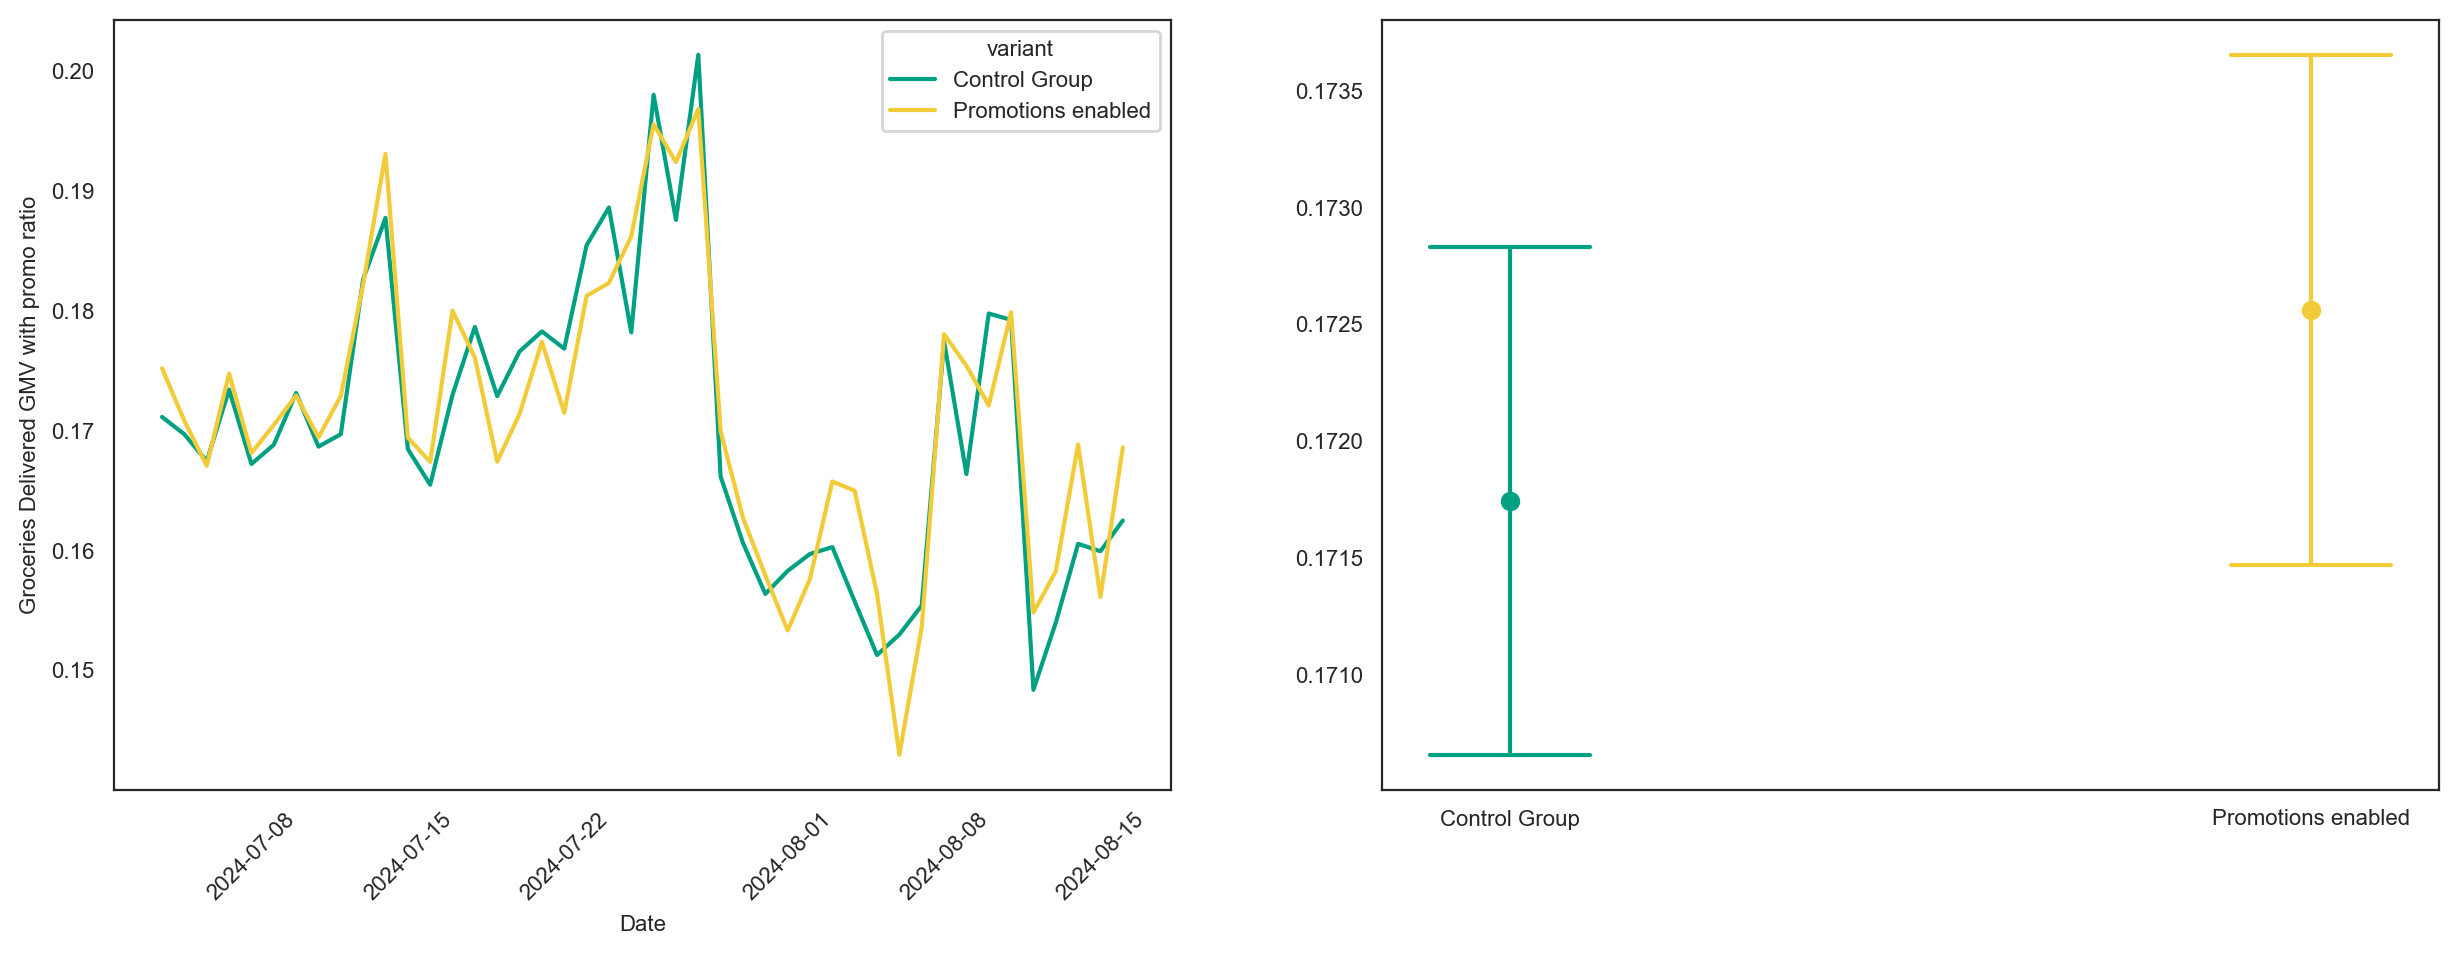

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES AOV                                                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,17.14563,17.09941,-0.04622,-0.10921,0.01676,0.10001,0.02810,False


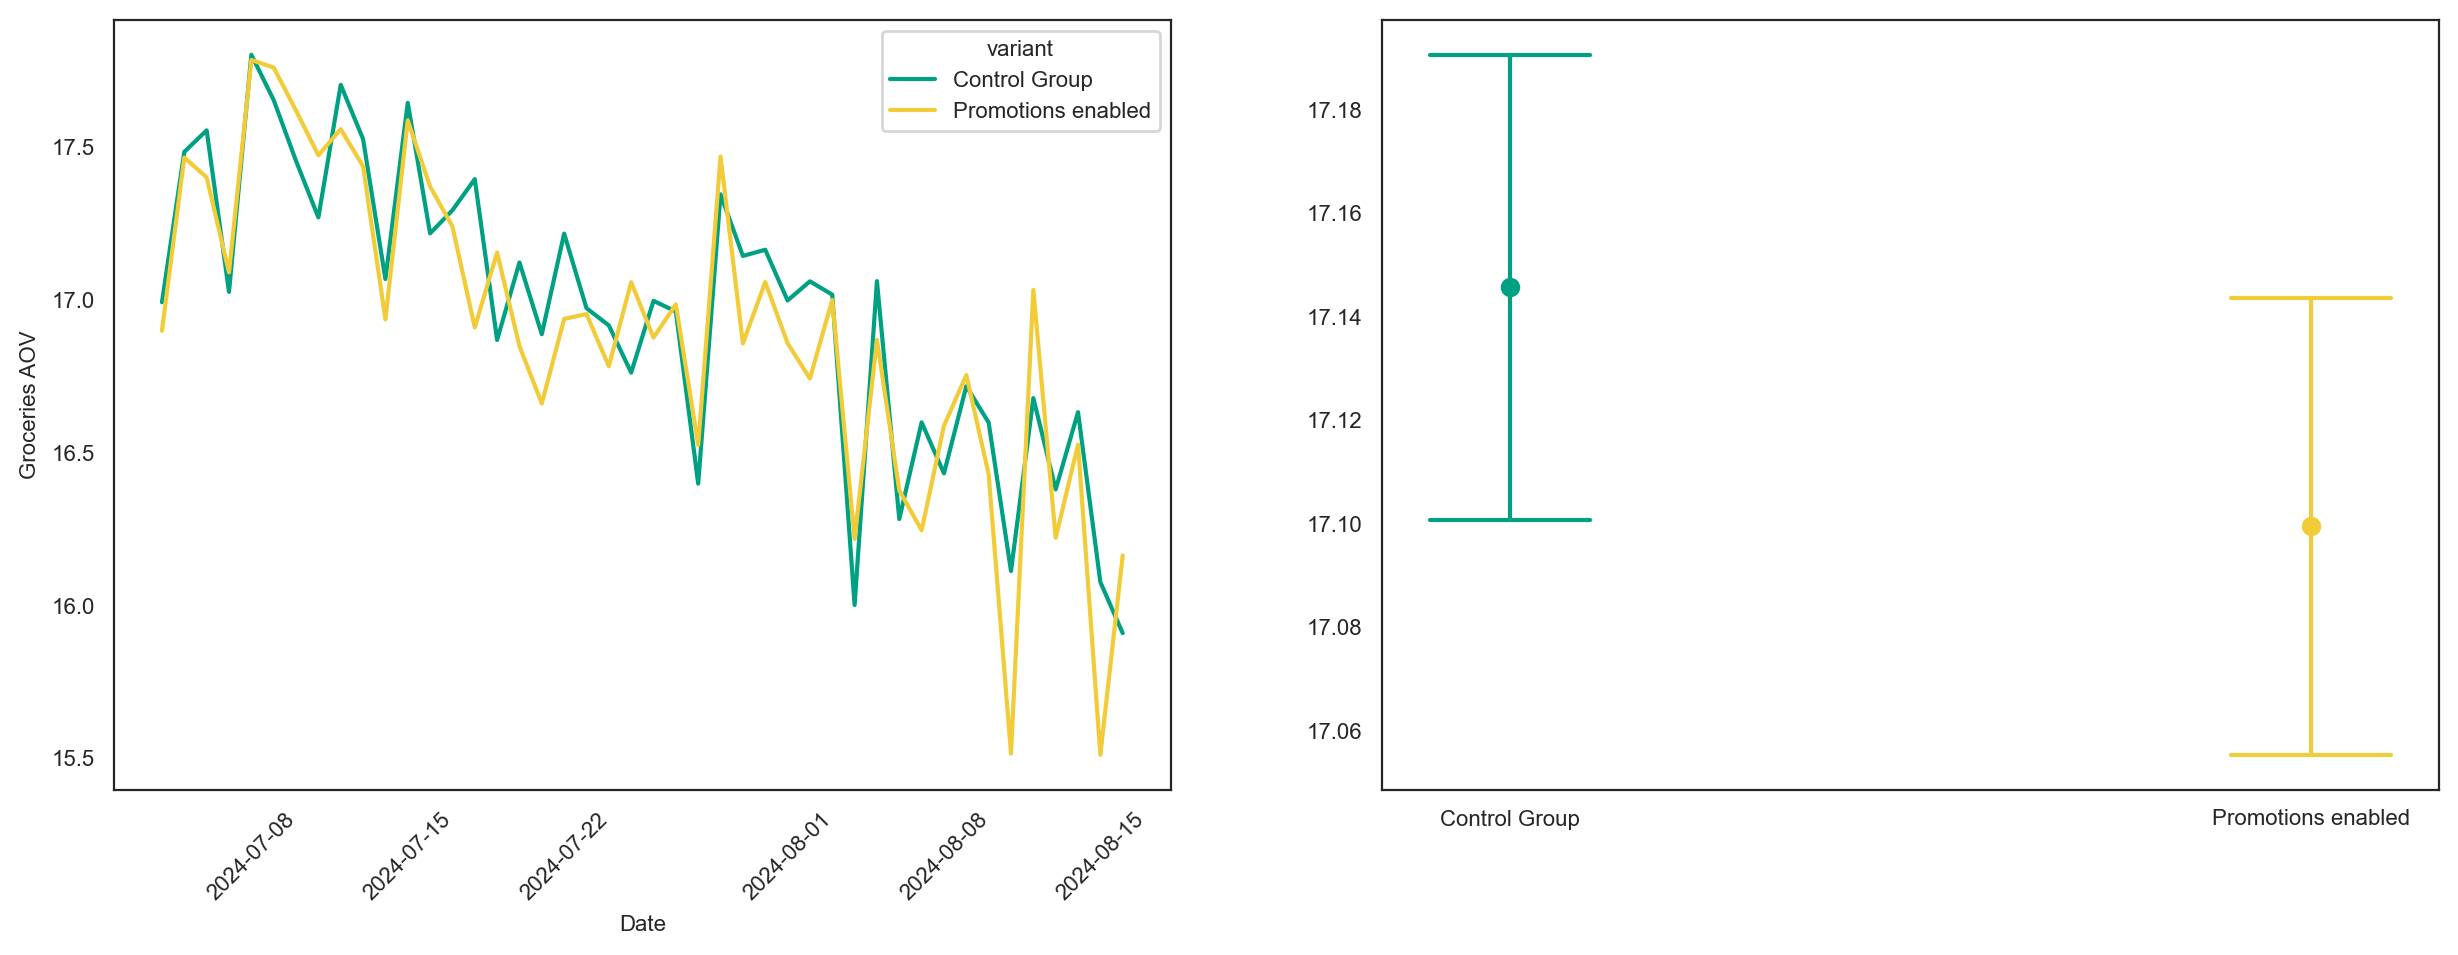

In [115]:
### Order level metrics

from glovo_experimentation_analytics.analytics.experiment import Experiment

experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "",
        "start_date": "2024-07-04",
        "end_date": "2024-08-16",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "Groceries Delivered GMV with promo ratio",
                "df": df_orders_clean.query('groceries_total_purchase_eur > 0'),
                "analysis_type": "clustered_ols",
                "cluster_cols" : ["customer_id"],
                "metric_col": "dGMV",
            },
            {
                "metric_name": "Groceries AOV",
                "df": df_orders_clean.query('groceries_orders > 0'),
                "analysis_type": "clustered_ols",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_aov",
            },
        ],
         "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": False
    }

exp_orders = Experiment.from_dict(experiment_config)
exp_orders.full_analysis()

In [116]:
## Get Experiment Scorecard
exp_orders_results = pd.DataFrame(exp_orders.get_scorecard_summary())

In [117]:
exp_orders_results.to_clipboard()

                                              Experiment Information                                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃               ┃            ┃               ┃               ┃               ┃             ┃       ┃        Alpha ┃
┃ Name          ┃ Hypothesis ┃          Date ┃       Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing     │            │ 2024-07-04 to │       ['GRC - │     ['Control │       False │  0.05 │       0.0125 │
│ promos for    │            │    2024-08-16 │     Groceries │       Group', │             │       │              │
│ Groceries     │            │               │ Delivered GMV │   'Promotions │             │       │              │
│               │            │               │    with promo │     enabled'] │             │       │              │
│               │            │               │  ratio', 'GNC │               │             │       │              │
│               │            │               │   - Groceries │               │             │       │              │
│               │            │               │ Delivered GMV │               │             │       │              │
│               │            │               │    with promo │               │             │       │              │
│               │            │               │  ratio', 'GRC │               │             │       │              │
│               │            │               │   - Groceries │               │             │       │              │
│               │            │               │  AOV', 'GNC - │               │             │       │              │
│               │            │               │     Groceries │               │             │       │              │
│               │            │               │         AOV'] │               │             │       │              │
└───────────────┴────────────┴───────────────┴───────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GRC - GROCERIES DELIVERED GMV WITH PROMO RATIO                                                                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.16383,0.16427,0.00044,-0.00141,0.00229,0.55087,0.00074,False


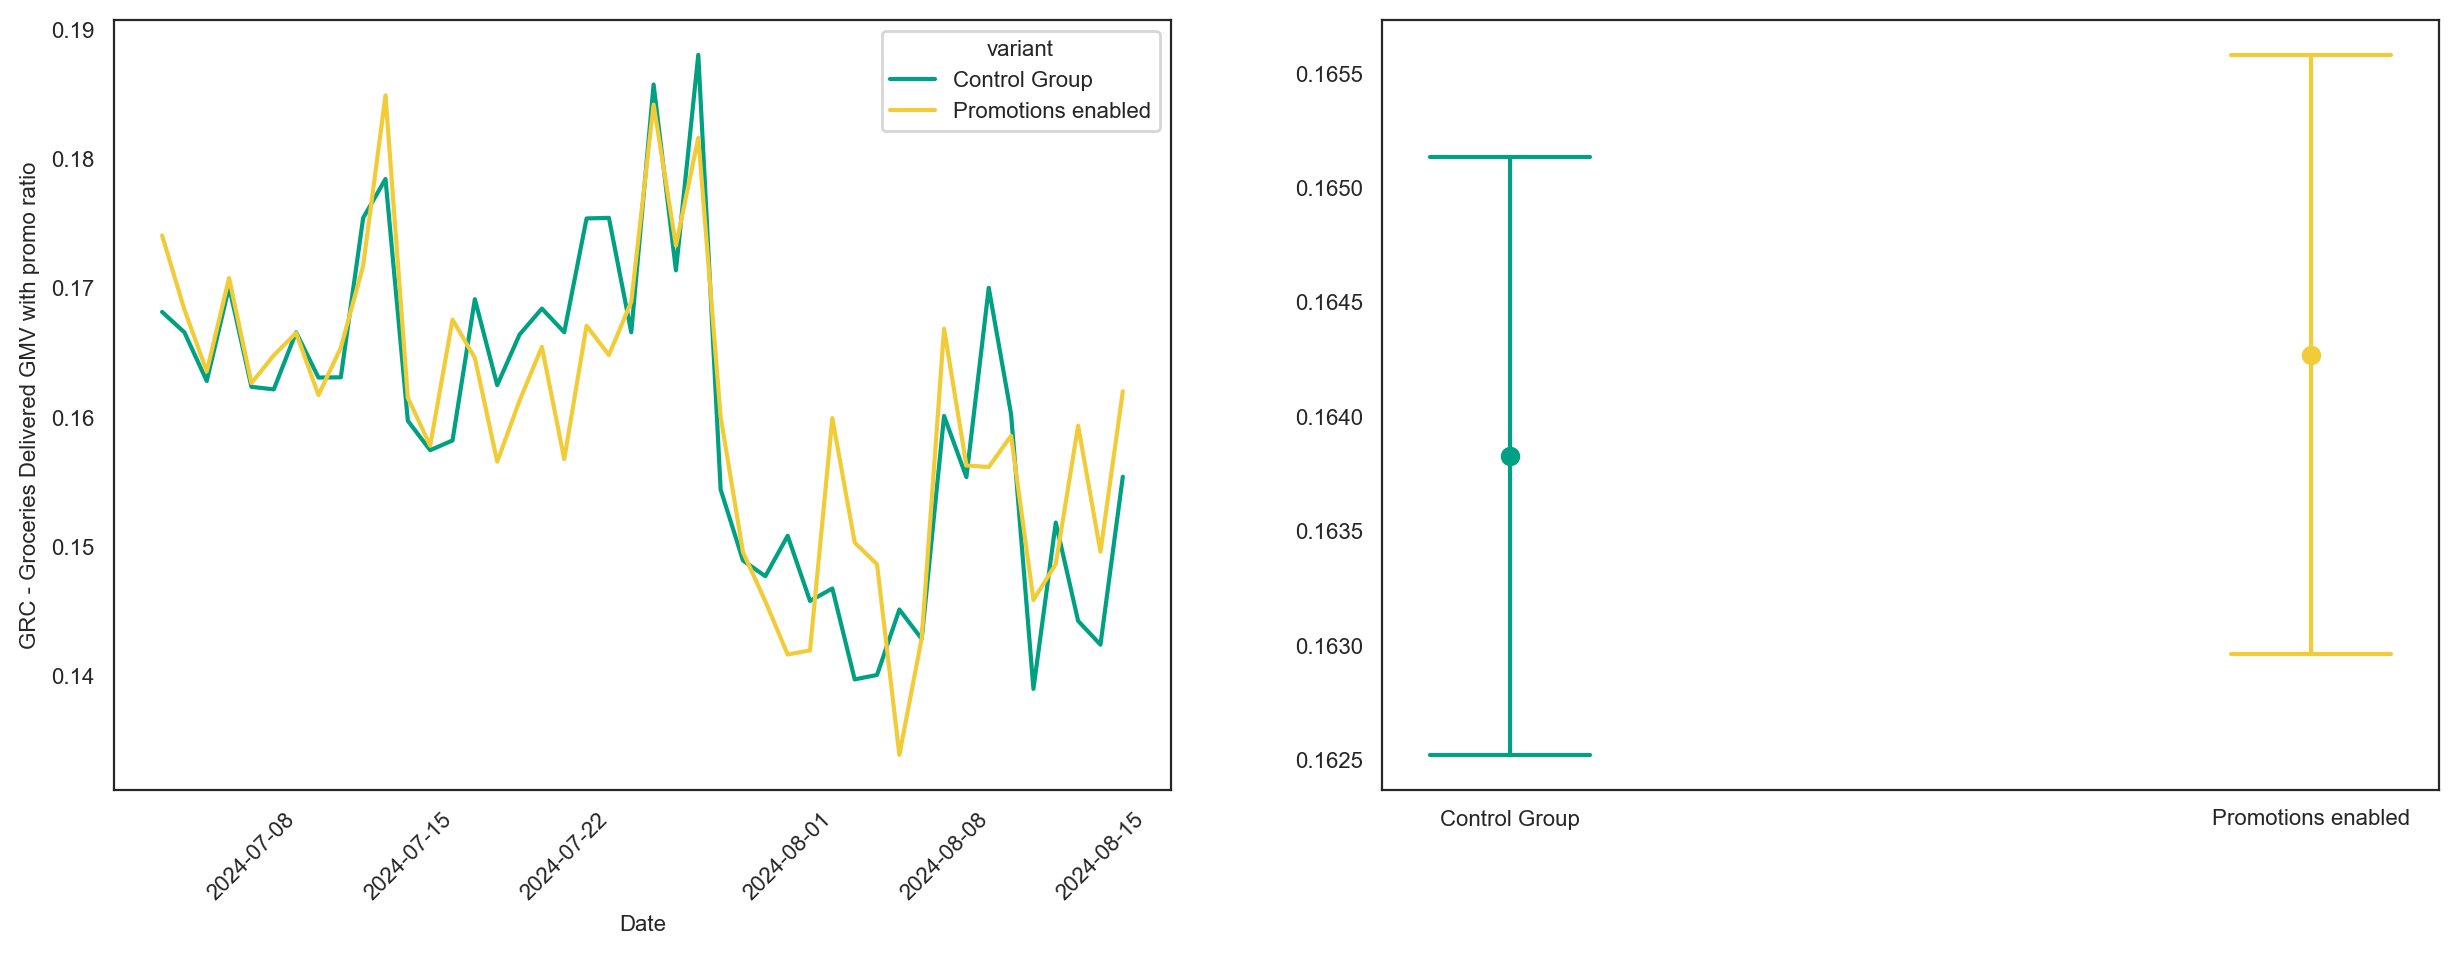

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GNC - GROCERIES DELIVERED GMV WITH PROMO RATIO                                                                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.20106,0.20372,0.00266,-0.00173,0.00706,0.13010,0.00176,False


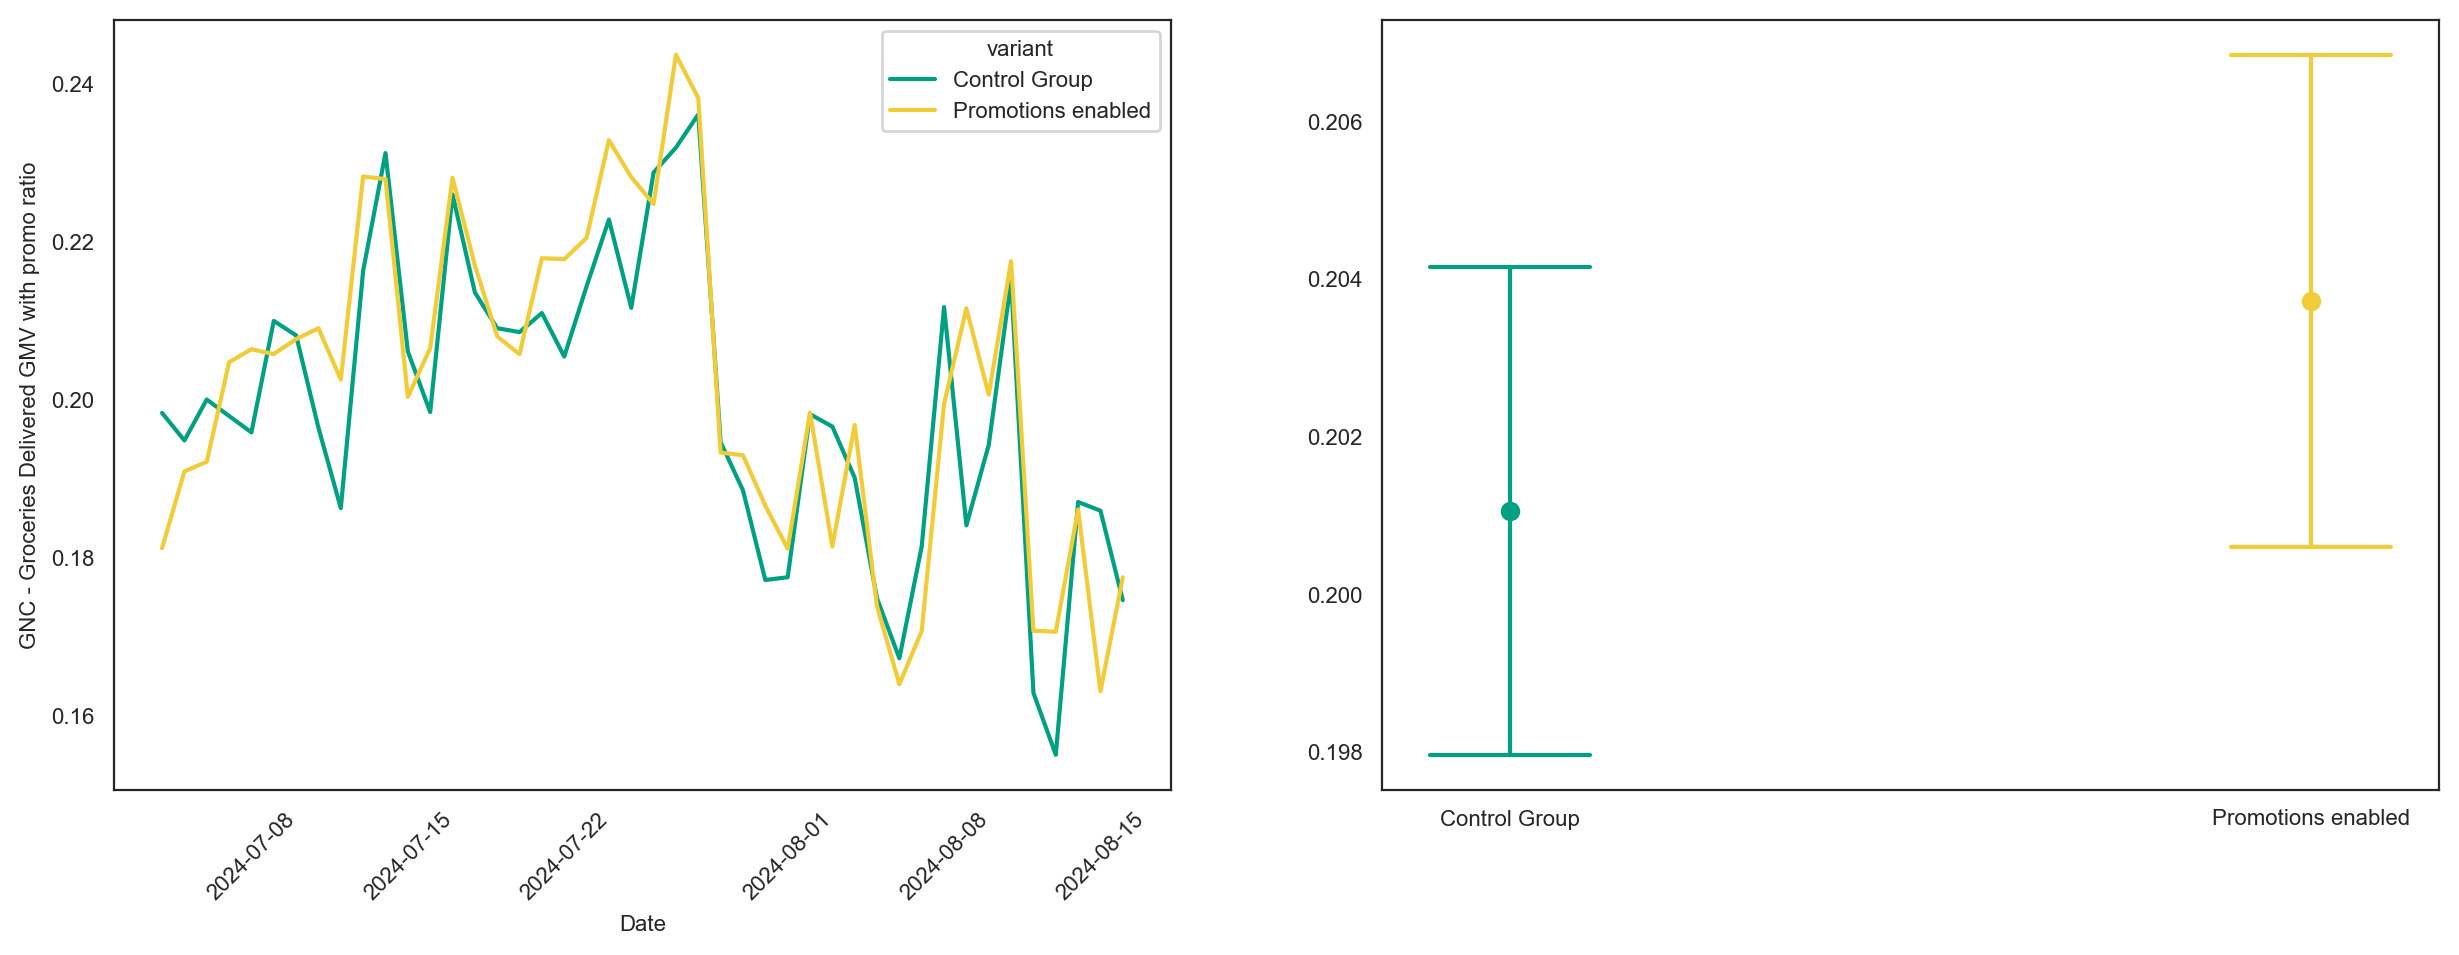

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GRC - GROCERIES AOV                                                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,17.85255,17.79227,-0.06028,-0.13865,0.01808,0.05469,0.03137,False


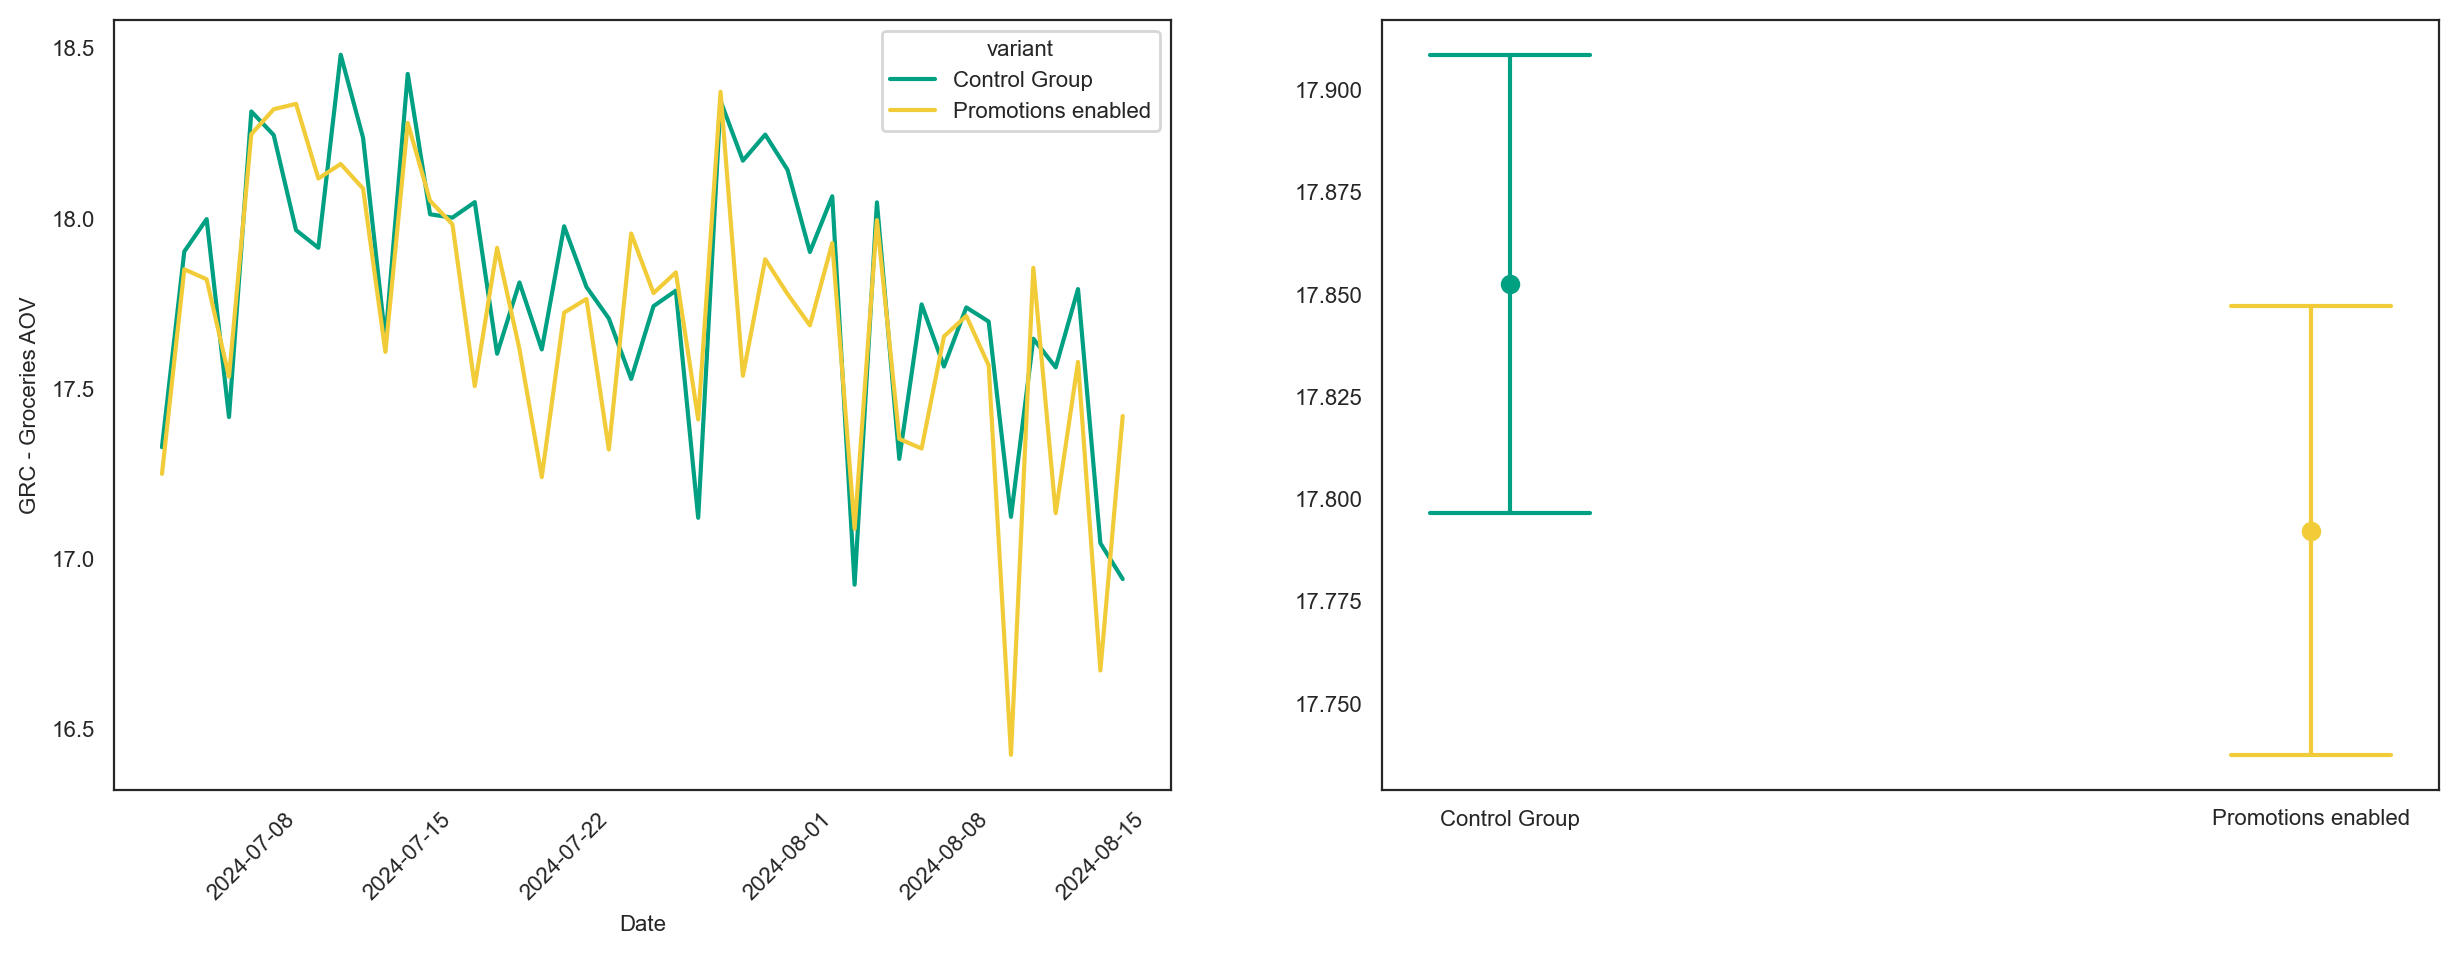

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GNC - GROCERIES AOV                                                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,14.47047,14.47533,0.00486,-0.15418,0.16389,0.93921,0.06367,False


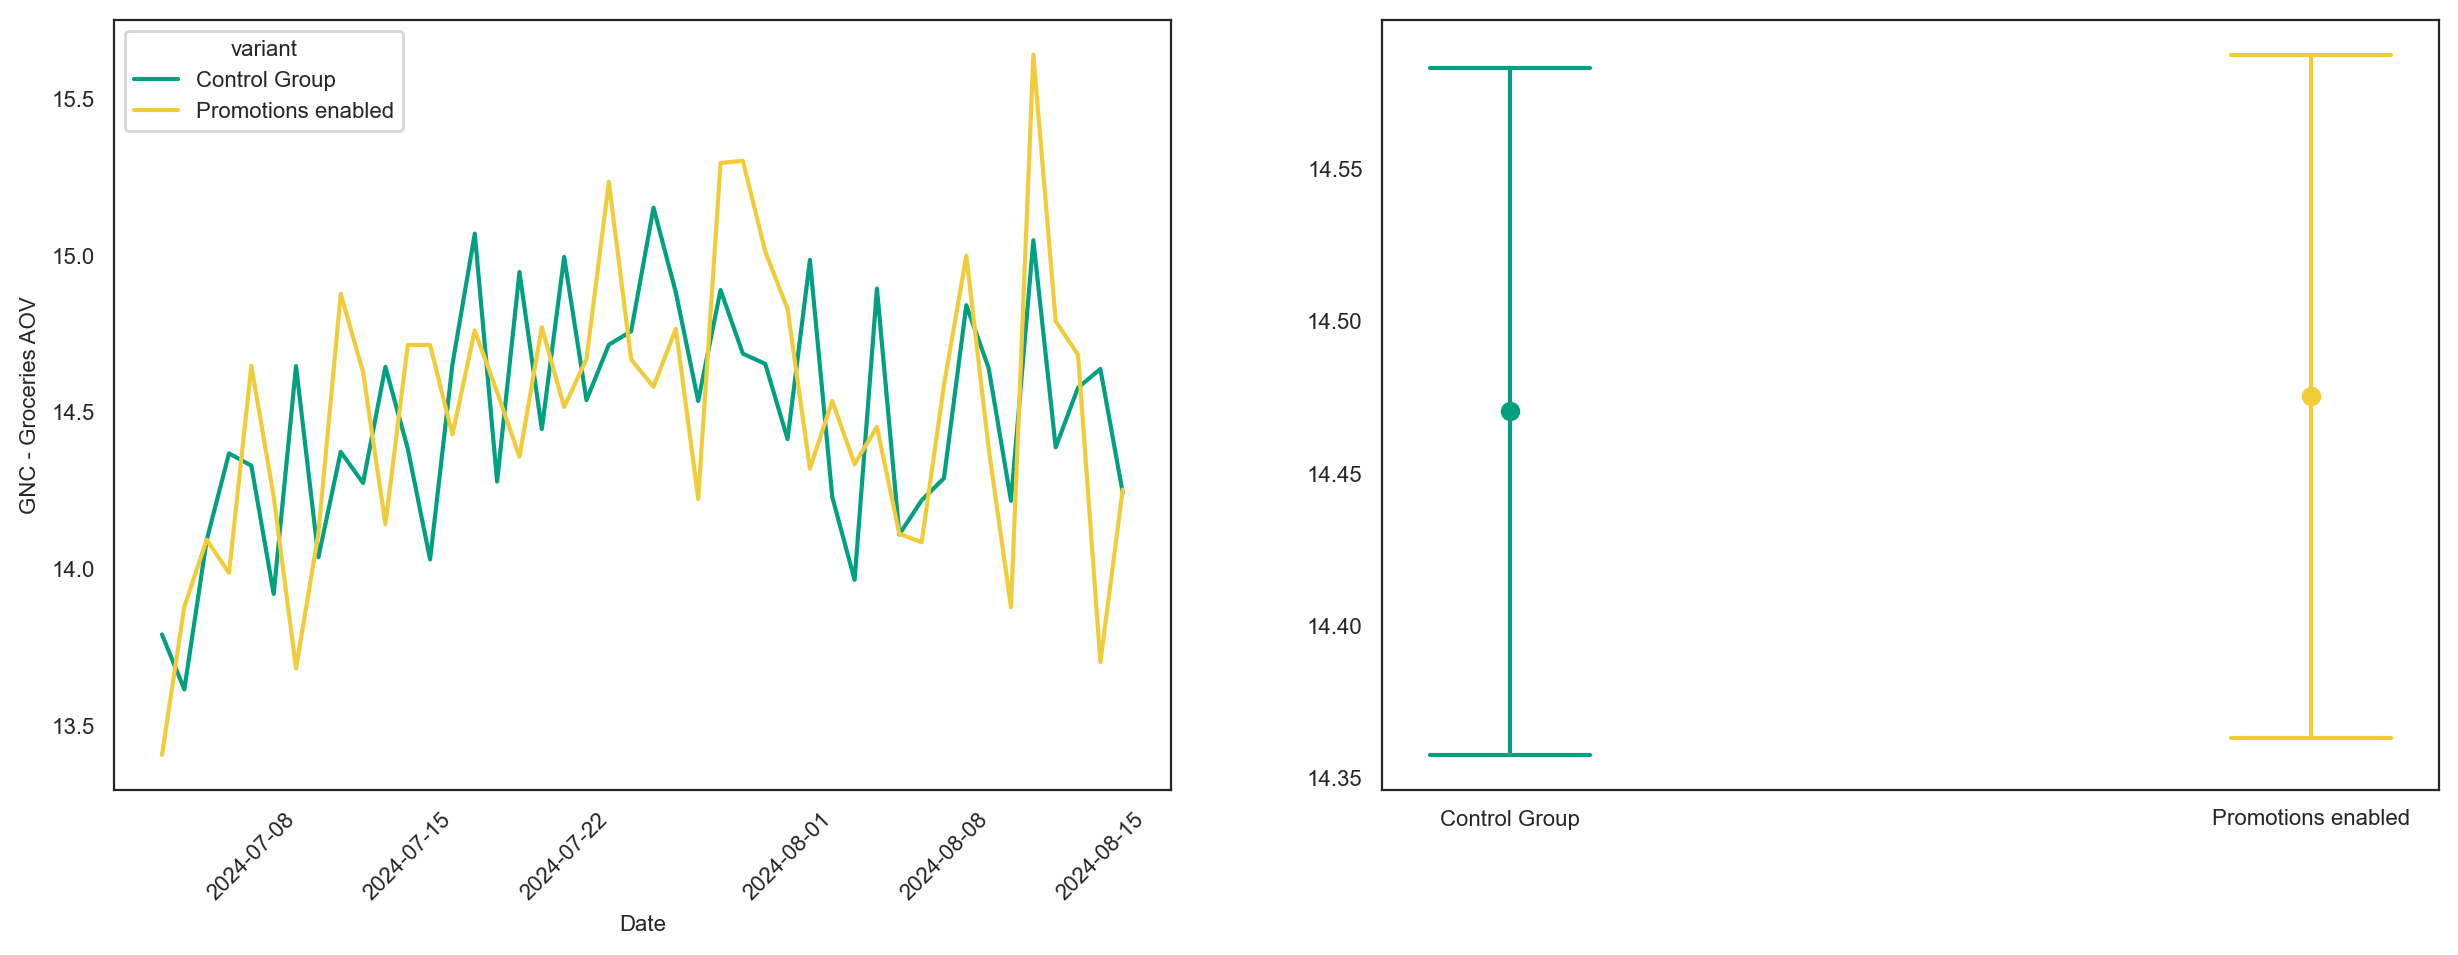

In [119]:
### Order level metrics by GRC/GNC

from glovo_experimentation_analytics.analytics.experiment import Experiment

experiment_config = {
       "name": "Surfacing promos for Groceries",
        "hypothesis": "",
        "start_date": "2024-07-04",
        "end_date": "2024-08-16",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "GRC - Groceries Delivered GMV with promo ratio",
                "df": df_orders_clean.query('(groceries_total_purchase_eur > 0) & (is_recurrent_groceries == 1)'),
                "analysis_type": "clustered_ols",
                "cluster_cols" : ["customer_id"],
                "metric_col": "dGMV",
            },
            {
                "metric_name": "GNC - Groceries Delivered GMV with promo ratio",
                "df": df_orders_clean.query('(groceries_total_purchase_eur > 0) & (is_recurrent_groceries == 0)'),
                "analysis_type": "clustered_ols",
                "cluster_cols" : ["customer_id"],
                "metric_col": "dGMV",
            },
            {
                "metric_name": "GRC - Groceries AOV",
                "df": df_orders_clean.query('(groceries_orders > 0) & (is_recurrent_groceries == 1)'),
                "analysis_type": "clustered_ols",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_aov",
            },
            {
                "metric_name": "GNC - Groceries AOV",
                "df": df_orders_clean.query('(groceries_orders > 0) & (is_recurrent_groceries == 0)'),
                "analysis_type": "clustered_ols",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_aov",
            },
        ],
         "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": False
    }

exp_orders_cohort = Experiment.from_dict(experiment_config)
exp_orders_cohort.full_analysis()

In [121]:
### Get Experiment Scorecard
exp_orders_cohort_results = pd.DataFrame(exp_orders_cohort.get_scorecard_summary())
exp_orders_cohort_results.to_clipboard()